# Расчет бизнес метрик

В нашем распоряжении данные одного сервиса: лог сервера с данными о посещениях сайта, выгрузка всех заказов за рассмативаемый период, статистика рекламных расходов.  
  
Цель нашего исследования - помочь маркетологам оптимизировать маркетинговые затраты.

В этом проекте мы рассчитаем метрики продукта, продаж и маркетинга.  
  
Метрики продукта:  
  
  
- посещаемость сервиса;
- DAU, WAU, MAU;
- средняя длительность сессии (ASL);
- Retention Rate.  
  
Метрики продаж:  
  
- сколько времени пользователям требуется на покупку;
- количество покупок на одного пользователя;
- конверсия в покупку;
- средний чек;
- сколько денег приносит один клиент (LTV).  
  
Метрики маркетинга:  
  
- затраты;
- затраты на привлечение одного покупателя (CAC);  
- насколько окупились расходы (ROMI).

В заключение мы сделаем выводы и оставим рекомендации маркетологам.

## Работа над проектом

### Шаг 1. Загрузка и предобработка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

In [3]:
def first_look_on_data(data, n):
    """
    Выводит основную информацию по датасету:
    первые n строк;
    размер;
    информацию о типах столбцов;
    имена столбцов;
    число пропусков в столбцах;
    число дубликатов;
    уникальные значения столбцов для типа object, int и 
    и столбцов, содержащих в названии 'id';
    таблицу describe для типов данных int и float.
    """
    print ('\033[1m' + f'Первые {n} строк:' + '\033[0m')
    display(data.head())
    print('-------------------------------------------------------------------------')
    print ('\033[1m' + 'Info' + '\033[0m')
    data.info()
    print('-------------------------------------------------------------------------')
    print(f'В датасете {data.shape[0]} строк и {data.shape[1]} столбцов.')
    print('-------------------------------------------------------------------------')
    print ('\033[1m' + 'Названия столбцов' + '\033[0m')
    print(data.columns)
    print('-------------------------------------------------------------------------')  
    print ('\033[1m' + 'Число пропусков:' + '\033[0m')
    print(data.isna().sum())
    print('-------------------------------------------------------------------------')
    print ('\033[1m' + 'Число дубликатов:' + '\033[0m')
    print(data.duplicated().sum())
    print('-------------------------------------------------------------------------')
    print ('\033[1m' + 'Уникальные значения столбцов:' + '\033[0m')
    print()

    for col in data.columns:
        if 'id' in col.lower():
            print(data[col].value_counts())
            print()
        elif 'object' in data[col].dtype.name:
            print(data[col].value_counts())
            print()
        elif 'datetime' in data[col].dtype.name:
            print(data[col].describe())
            print() 
        elif 'float' in data[col].dtype.name:
            print(data[col].describe())
            print() 
        else:
            print(data[col].describe())
            print()
            print(data[col].value_counts())
            print()

In [4]:
visits_data = pd.read_csv('../datasets/visits_log.csv', parse_dates=['End Ts', 'Start Ts'])

In [5]:
first_look_on_data(visits_data, 5)

Первые 5 строк:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


-------------------------------------------------------------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
-------------------------------------------------------------------------
В датасете 359400 строк и 5 столбцов.
-------------------------------------------------------------------------
Названия столбцов
Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')
-------------------------------------------------------------------------
Число пропусков:
Device       0
End Ts  

В датасете 359400 строк и 5 столбцов. В названиях столбцов используются заглавные буквы и пробелы. Исправим это.  
Типы данных верные.  
Пропусков нет.  
Значения столбца `Device` корректны.  
Источников трафика всего 9, хотя идентификаторы в диапазоне от 1 до 10. В нашей выборке не представлены данные из источника с идентификатором 8. Также данных по источникам 6 и 7 очень мало.  
Даты начала сессий находятся в промежутке между 1 июня 2017 года и 31 мая 2018 года.
Даты окончания сессий находятся в промежутке между 1 июня 2017 и 1 июня 2018 года.  
Период наблюдений - 1 год.

In [6]:
visits_data = visits_data.rename(columns={c:c.replace(' ', '_').lower() for c in visits_data.columns})
visits_data.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [7]:
orders_data = pd.read_csv('../datasets/orders_log.csv', parse_dates=['Buy Ts'])

In [8]:
first_look_on_data(orders_data, 5)

Первые 5 строк:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


-------------------------------------------------------------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
-------------------------------------------------------------------------
В датасете 50415 строк и 3 столбцов.
-------------------------------------------------------------------------
Названия столбцов
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')
-------------------------------------------------------------------------
Число пропусков:
Buy Ts     0
Revenue    0
Uid        0
dtype: int64
-------------------------------------------------------------------------
Число дубликатов:
0
--------------------------

В датасете 50415 строк и 3 столбцов. Названия столбцов также содержат пробелы и заглавные буквы. Пропусков нет.  
Типы данных верные.  
Даты заказов находятся в диапазоне с 1 июня 2017 по 1 июня 2018 года.

Исправим названия столбцов.

In [9]:
orders_data = orders_data.rename(columns={c:c.replace(' ', '_').lower() for c in orders_data.columns})

Дополнительно проверим, нет ли в столбце с выручкой отрицательных значений.

In [10]:
orders_data[orders_data['revenue'] < 0].shape[0]

0

In [11]:
costs_data = pd.read_csv('../datasets/costs.csv', parse_dates=['dt'])

In [12]:
first_look_on_data(costs_data, 5)

Первые 5 строк:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


-------------------------------------------------------------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
-------------------------------------------------------------------------
В датасете 2542 строк и 3 столбцов.
-------------------------------------------------------------------------
Названия столбцов
Index(['source_id', 'dt', 'costs'], dtype='object')
-------------------------------------------------------------------------
Число пропусков:
source_id    0
dt           0
costs        0
dtype: int64
-------------------------------------------------------------------------
Число дубликатов:
0
-------------

Всего в датасете 2542 строк и 3 столбцов. С названиями столбцов всё в порядке.  
Пропусков нет. Типы данных верные.  
Диапазон значений столбца с датой - с 1 июня 2017 по 31 мая 2018 года.  
В нашем датасете информация о расходах только по 7 источникам трафика.  
Разброс значений самих расходов велик - больше среднего значения. Разница между максимальным и минимальным большая.

Проверим, нет ли в столбце с суммой расходов отрицательных значений.

In [13]:
costs_data[costs_data['costs'] < 0].shape[0]

0

## Шаг 2. Построение отчётов и расчет метрик

### Продукт

### Сколько людей пользуются продуктом в день, неделю, месяц.

In [14]:
visits_data.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [15]:
visits_data['session_date'] = visits_data['start_ts'].dt.date
visits_data['session_week'] = (pd.to_datetime(visits_data['start_ts'], unit='d') \
- pd.to_timedelta(visits_data['start_ts'].dt.dayofweek, unit='d')).dt.date
visits_data['session_month'] = visits_data['start_ts'].astype('datetime64[M]')

#### Рассчитаем количество уникальных пользователей в день.

In [16]:
dau = visits_data.groupby('session_date').agg(users_count = ('uid', 'nunique')).reset_index()

In [17]:
dau.head()

,session_date,users_count
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


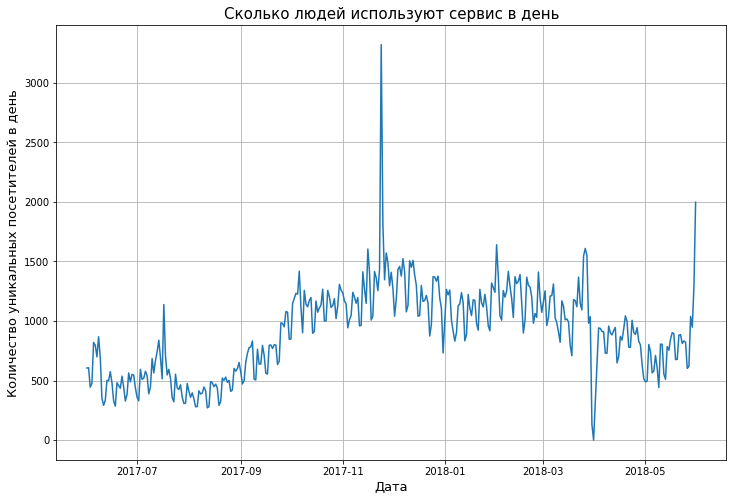

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pd.to_datetime(dau['session_date']), dau['users_count'])

ax.set_xlabel('Дата', fontsize=13)
ax.set_ylabel('Количество уникальных посетителей в день', fontsize=13)
ax.set_title('Сколько людей используют сервис в день', fontsize = 15)
ax.grid(True)
plt.show()

Если в начале рассматриваемого периода среднее количество посетителей в день колебалось около 500 человек, то с октября по март оно возросло до 1000 человек в день.

Бросается в глаза спад посетителей в районе 1.04.2018. 

In [19]:
dau[(dau['session_date'] >= pd.to_datetime('2018-03-28')) & (dau['session_date'] <= pd.to_datetime('2018-04-03'))]

,session_date,users_count
300,2018-03-28,981
301,2018-03-29,1037
302,2018-03-30,131
303,2018-03-31,1
304,2018-04-02,641
305,2018-04-03,942


За 1 апреля данных вообще нет. И заметно, что уже 30 марта количество посетителей заметно снизилось. Видимо, на сайте были какие-то технические неполадки. 

Среднее количество уникальных посетителей в день:

In [20]:
dau_total = int(dau.mean().round())
dau_total

908

#### Распределение посетителей в день в зависимости от используемого устройства.

In [21]:
dau_per_device = visits_data.groupby(['session_date', 'device']).agg(users_count = ('uid', 'nunique')).reset_index()

In [22]:
dau_per_device.head()

,session_date,device,users_count
0,2017-06-01,desktop,455
1,2017-06-01,touch,153
2,2017-06-02,desktop,458
3,2017-06-02,touch,152
4,2017-06-03,desktop,307


In [23]:
dau_per_device[dau_per_device['device'] == 'touch']['users_count'].mode()

0    102
1    325
dtype: int64

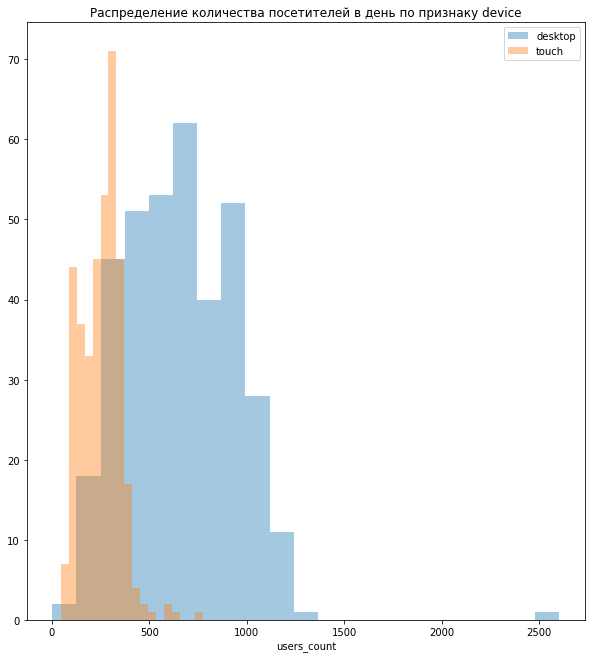

In [24]:
dau_per_device_grouped = dau_per_device.groupby('device')

fig, axes = plt.subplots(1, 1, figsize=(10, 11))

for name, group in dau_per_device_grouped:
    sns.distplot(group['users_count'].dropna(), kde=False, label=name)  
    axes.legend()
    axes.set(title=f'Распределение количества посетителей в день по признаку device')

Распределение числа посетителей в день похоже на нормальное. Гораздо больше посетителей предпочитают заходить с компьютера. Может быть, с мобильной версией сайта какие-то проблемы. Может быть, просто действительно удобнее совершать покупки основательно за компьютером, а не мимоходом со смартфона.

#### Распределение посетителей в день в зависимости от источника рекламы

In [25]:
visits_data['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [26]:
dau_per_source = visits_data.groupby(['session_date', 'source_id']).agg(users_count=('uid', 'count')).reset_index()

In [27]:
dau_per_source.groupby('source_id').describe()

users_count                                                     \
                count        mean         std   min    25%    50%    75%   
source_id                                                                  
1               364.0   93.739011   51.809680   1.0   59.0   91.0  120.0   
2               363.0  131.201102   65.523610  18.0   84.5  131.0  163.5   
3               363.0  235.840220   98.626321  32.0  154.0  238.0  305.0   
4               363.0  280.424242  124.095297  32.0  171.5  300.0  376.5   
5               363.0  184.311295   68.697387  33.0  134.5  181.0  227.0   
6                 6.0    1.000000    0.000000   1.0    1.0    1.0    1.0   
7                34.0    1.058824    0.238833   1.0    1.0    1.0    1.0   
9               363.0   36.575758   47.929353   1.0    9.5   22.0   52.5   
10              363.0   27.617080   19.365329   1.0   14.0   23.0   37.0   

                  
             max  
source_id         
1          615.0  
2          649.0  
3          965.0  
4          783.0  
5          427.0  
6            1.0  
7            2.0  
9          567.0  
10         135.0

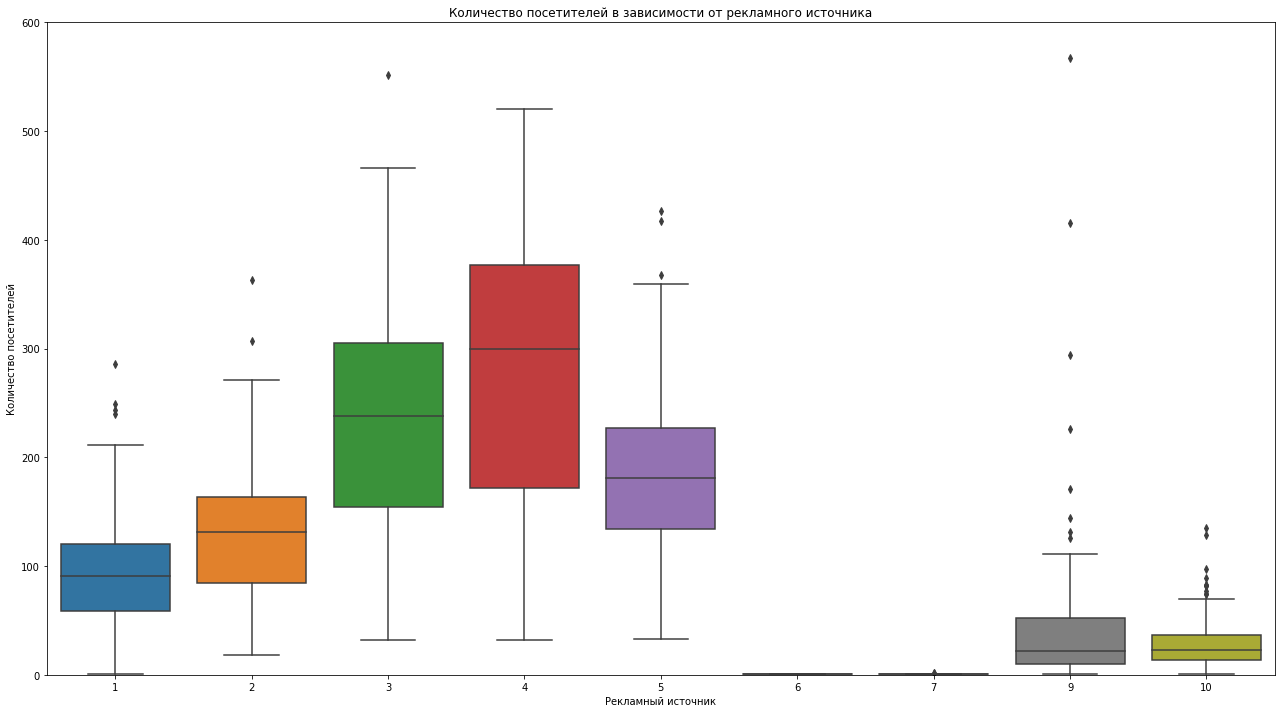

In [28]:
fig, ax = plt.subplots(1, 1,figsize=(22, 12))

ax.set_ylim([0, 600])  

sns.boxplot(x="source_id", y="users_count", data=dau_per_source, ax=ax).set(
    xlabel='Рекламный источник', 
    ylabel='Количество посетителей',
title="Количество посетителей в зависимости от рекламного источника")

plt.show()

Больше всего посетителей приходит из источника 4. Источник 3 приводит также достаточно много пользователей.  
Источники 5 и 2 заметно отстают по количеству посетителей, но из них люди приходят. В то время как из источника 6, 7 в среднем приходит 1 человек в день. Источники 9 и 10 также не могут похвастаться большой аудиторией.  
Может, в принципе в этих источниках меньше потенциальных посетителей. 

#### Количество уникальных пользователей в неделю

In [29]:
wau = visits_data.groupby('session_week').agg({'uid': 'nunique'}).reset_index()

In [30]:
wau.head()

,session_week,uid
0,2017-05-29,2021
1,2017-06-05,4129
2,2017-06-12,2812
3,2017-06-19,2878
4,2017-06-26,3064


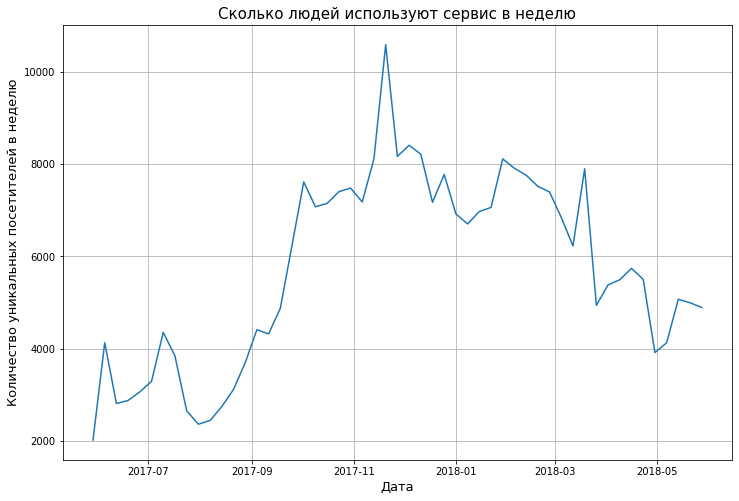

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.plot(pd.to_datetime(wau['session_week']), wau['uid'])

axes.set_title('Сколько людей используют сервис в неделю', fontsize = 15)
axes.set_xlabel('Дата', fontsize = 13)
axes.set_ylabel('Количество уникальных посетителей в неделю', fontsize = 13)
axes.grid(True)
plt.show()

С октября 2017 по март 2018 количество посетителей в неделю было заметно больше. В августе 2017 года был большой спад количества посетителей.

#### Среднее количество посетителей в неделю

In [32]:
wau_total = int(wau.mean().round())
wau_total

5716

#### Количество уникальных пользователей в месяц

In [33]:
mau = visits_data.groupby('session_month').agg({'uid': 'nunique'}).reset_index()

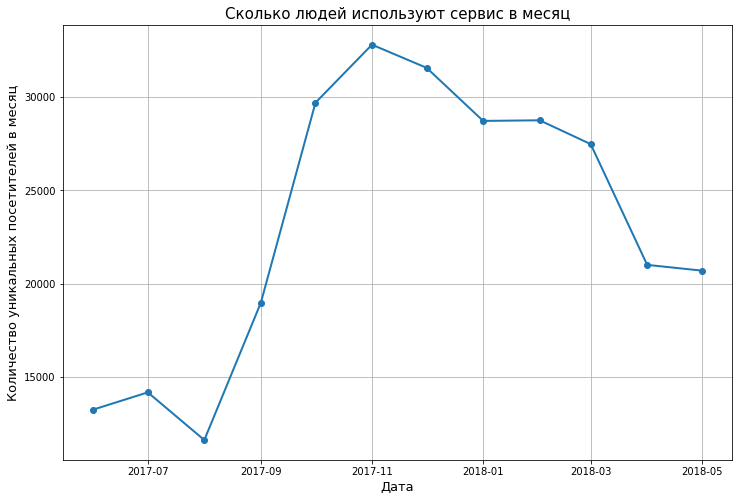

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

axes.plot(pd.to_datetime(mau['session_month']), mau['uid'], lw=2, marker='o')

axes.set_title('Сколько людей используют сервис в месяц', fontsize = 15)
axes.set_xlabel('Дата', fontsize = 13)
axes.set_ylabel('Количество уникальных посетителей в месяц', fontsize = 13)
axes.grid(True)
plt.show()

Картина по месяцам та же. Радует, что падение числа посетителей в апреле-мае 2018 не дошло до уровня августа 2017 года.

#### Среднее количество уникальных пользователей в месяц 

In [35]:
mau_total = int(mau.mean().round())
mau_total

23228

#### Количество уникальных посетителей в месяц в зависимости от устройства

In [36]:
mau_per_device_table = visits_data\
.pivot_table(index='session_month', columns='device', values='uid', aggfunc='count')\
.reset_index()

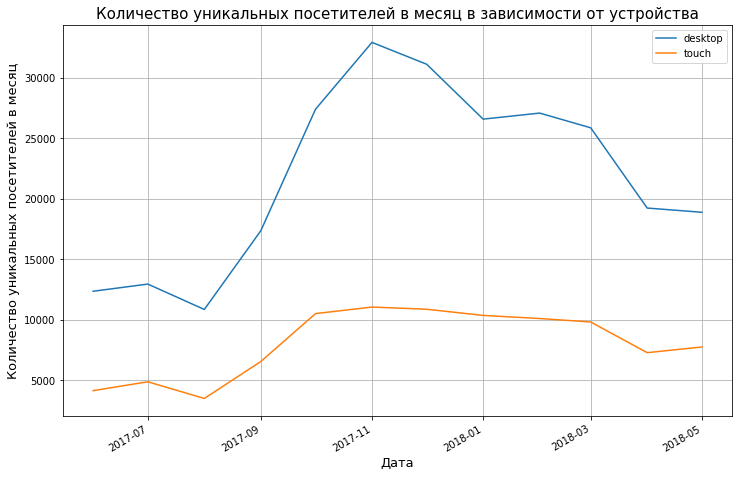

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pd.to_datetime(mau_per_device_table['session_month']), mau_per_device_table['desktop'], label='desktop')
mau_per_device_table.plot(x='session_month', y='touch', ax = ax)
ax.set_xlabel('Дата', fontsize=13)
ax.set_ylabel('Количество уникальных посетителей в месяц', fontsize=13)
ax.set_title('Количество уникальных посетителей в месяц в зависимости от устройства', fontsize = 15)
ax.legend()
ax.grid(True)
plt.show()

В помесячном разрезе видно, что до сентября 2017 года разница в количестве пользователей на разных устройствах была стабильна. Уже в ноябре произошло сильное увеличение числа посетителей с устройства `desktop`, а вот на устройствах `touch` заметное плато.  
Либо с мобильной версией сайта действительно какие-то проблемы, либо источники привлечения посетителей каким-то образом привлекают людей, использующих настольные компьютеры. 

#### Количество уникальных посетителей в месяц в зависимости от рекламного источника

In [38]:
mau_per_source_table = visits_data.query('source_id != 6 & source_id != 7')\
.pivot_table(index='session_month', columns='source_id', values='uid', aggfunc='count')\
.reset_index()

In [39]:
mau_per_source_table

source_id,session_month,1,2,3,4,5,9,10
0,2017-06-01,1544,2191,4435,3911,3122,823,477
1,2017-07-01,1641,2488,4276,4402,4056,621,341
2,2017-08-01,1251,1866,3582,3298,3403,684,269
3,2017-09-01,2082,3025,6102,5791,5489,874,540
4,2017-10-01,3282,4642,9017,10484,8303,1166,1004
5,2017-11-01,4518,6084,10802,12582,7256,1669,1056
6,2017-12-01,4396,5630,9724,13144,6940,1421,718
7,2018-01-01,3277,4697,8951,11223,6353,1170,1263
8,2018-02-01,3427,4679,9169,10653,6724,1122,1403
9,2018-03-01,3508,4707,8059,10647,5258,2067,1432


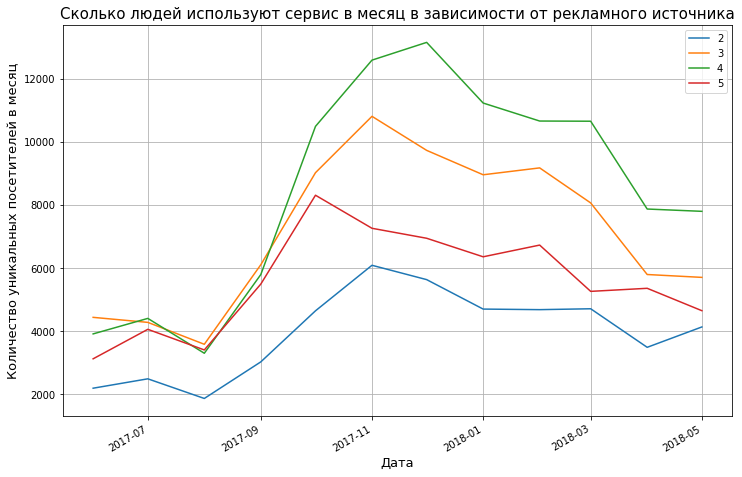

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pd.to_datetime(mau_per_source_table['session_month']), mau_per_source_table[2], label='2')
for col in mau_per_source_table.columns[3:6]:
    mau_per_source_table.plot(x='session_month', y=col, ax = ax)
ax.set_xlabel('Дата', fontsize=13)
ax.set_ylabel('Количество уникальных посетителей в месяц', fontsize=13)
ax.set_title('Сколько людей используют сервис в месяц в зависимости от рекламного источника', fontsize = 15)
ax.legend()
ax.grid(True)
plt.show()

В помесячном разрезе сглаживаются недельные различия и видно, что до октября рекламные источники 3, 4, 5 привлекали приблизительно одинаковое число людей. После октября источник 4 начал сильно лидировать, а источник 5 сильно проседать. Может быть, было уменьшено финансирование в источник 5 или наоборот увеличено в источник 4.

### Сколько сессий в день

In [41]:
sessions_per_user = visits_data\
.groupby('session_date')\
.agg(n_sessions = ('uid', 'count'), n_users = ('uid', 'nunique'))\
.assign(sessions_per_user=lambda x: x['n_sessions']/x['n_users'])

In [42]:
sessions_per_user.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [43]:
int(sessions_per_user['sessions_per_user'].mean().round())

1

#### Среднее количество сессий на одного посетителя в зависимости от устройства

In [44]:
sessions_by_device_table = visits_data\
.pivot_table(index='session_date', columns='device', values='uid', aggfunc=['count', 'nunique'])\
.assign(desktop=lambda x: x['count', 'desktop']/x['nunique', 'desktop'])\
.assign(touch=lambda x: x['count', 'touch']/x['nunique', 'touch'])\
.reset_index()

In [45]:
sessions_by_device_table[['desktop', 'touch']].mean()

         device
desktop            1.088955
touch              1.051072
dtype: float64

Устройство не влияет на количество сессий в день для одного пользователя.

#### Среднее количество сессий на одного посетителя в зависимости от рекламного источника

In [46]:
visits_data\
.groupby(['session_date', 'source_id'])['uid'].agg(['count', 'nunique'])\
.eval('sess_count_per_user = count / nunique')['sess_count_per_user']\
.reset_index()\
.groupby('source_id')['sess_count_per_user'].mean()

source_id
1     1.153998
2     1.082435
3     1.011951
4     1.016622
5     1.048359
6     1.000000
7     1.000000
9     1.011676
10    1.048194
Name: sess_count_per_user, dtype: float64

Можно увидеть, что из первого источника люди проводят чуть больше сессий. Но если округлять до целых - число сессий не меняется в зависимости от рекламного источника.  
В среднем пользователи проводят в приложении одну сессию в день. Учитывая, что мы анализируем сайт с афишей событий, не стоит ожидать, что пользователи будут проводить на нем несколько сессий в день, как в онлайн-играх.

### Сколько длится одна сессия?

#### Найдем среднюю продолжительность сессии (ASL).

In [47]:
visits_data['session_duration_sec'] = (visits_data['end_ts'] - visits_data['start_ts']).dt.total_seconds()

In [48]:
visits_data['session_duration_sec'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

Обнаружили в столбце с длиной сессии отрицательные значения. Значит, где-то время окончания меньше времени начала сессии. Возможно, были какие-то сбои в сборе данных.

In [49]:
visits_data[visits_data['session_duration_sec'] < 0]['session_duration_sec'].count()

2

Посмотрим, что это за строки.

In [50]:
wrong_ids = visits_data[visits_data['session_duration_sec'] < 0].index

In [51]:
visits_data.loc[wrong_ids]

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_duration_sec
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,2018-03-19,2018-03-01,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,2018-03-19,2018-03-01,-2760.0


In [52]:
orders_data[orders_data['uid'] == 13092152539246794986]

,buy_ts,revenue,uid


In [53]:
orders_data[orders_data['uid'] == 4621202742905035453]

,buy_ts,revenue,uid


Так как в нашем датасете 359400 строк и пользователи с этими `uid` не совершали заказов, удаление двух строк не скажется на результатах исследования. Избавимся от строк с неверными датами сессий.

In [54]:
visits_data = visits_data.drop(wrong_ids)

In [55]:
visits_data['session_duration_sec'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

In [56]:
visits_data['session_duration_sec'].mode()

0    60.0
dtype: float64

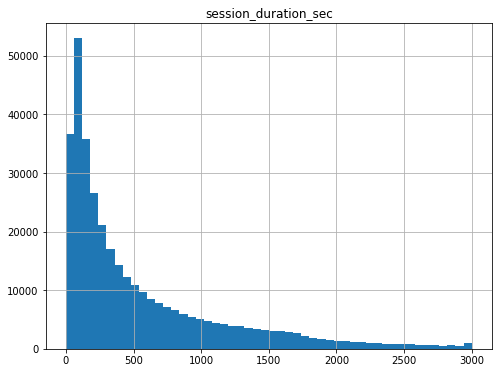

In [57]:
visits_data\
.hist(column='session_duration_sec', bins=50, range=(0, 3000), figsize=(8,6));

In [58]:
(visits_data['session_duration_sec']\
 .value_counts(normalize=True)*100).round(4)


60.0       14.7550
0.0         9.9594
120.0       9.9466
180.0       7.4213
240.0       5.8668
            ...   
15360.0     0.0003
22440.0     0.0003
31440.0     0.0003
19020.0     0.0003
14340.0     0.0003
Name: session_duration_sec, Length: 310, dtype: float64

В распределении около 10% сессий нулевой длительности. Это значит, что пользователь просто в этой сессии ничего не сделал, только перешел на сайт. Он мог просто смотреть афишу на главной странице.

Так как наше распределение не похоже на нормальное, среднее значение не будет объективным. Это видно и по статистикам - среднее в 2 раза больше медианы. Медиана равна 300 секунд. Мода равна 60 секунд. В распределении довольно длинный хвост с большими  значениями. Также достаточно много посетителей и с длиной сессии больше 500 секунд, так что мода не будет так точно характеризовать среднее значение нашего распределения. В качестве средней меры выберем медиану. Для покупки этого времени вполне достаточно.

Также видим, что в распределении около 15% сессий длины 60 секунд. Видимо, эти пользователи заглядывали, чтобы ознакомиться с афишей ближайших событий и вернуться позже.

#### Средняя длительность сессии в зависимости от устройства

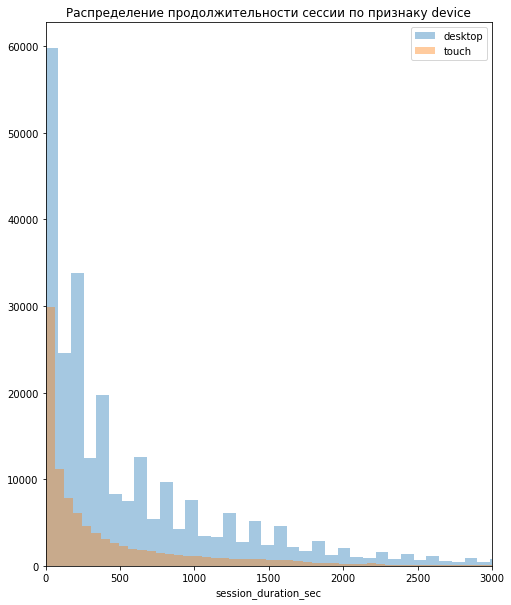

In [59]:
visits_data_per_device_grouped = visits_data.groupby('device')

fig, axes = plt.subplots(1, 1, figsize=(8,10))

for name, group in visits_data_per_device_grouped:
    sns.distplot(group['session_duration_sec'].dropna(), kde=False, label=name, bins=500) 
    axes.set_xlim(0, 3000)
    axes.legend()
    axes.set(title=f'Распределение продолжительности сессии по признаку device')

In [60]:
visits_data_per_device_grouped['session_duration_sec'].describe()

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,262565.0,703.312041,1067.030043,0.0,120.0,360.0,900.0,42660.0
touch,96833.0,479.619407,752.531533,0.0,60.0,180.0,600.0,30840.0


Медиана на устройстве `desktop` стала больше на минуту и составляет 360 секунд в то время как на устройствах `touch` медиана меньше и составляет 180 секунд. Либо мобильная версия в порядке и люди успевают совершить заказ за меньшее время, чем на компьютере, либо с мобильной версией проблемы, поэтому средняя продолжительность сессии здесь меньше.

#### Средняя длительность сессии в зависимости от источника рекламы

In [61]:
visits_data_per_source_grouped = visits_data.groupby('source_id')

In [62]:
visits_data_per_source_grouped['session_duration_sec'].apply(lambda x: x.mode())

source_id   
1          0      60.0
2          0      60.0
3          0      60.0
4          0      60.0
5          0      60.0
6          0       0.0
           1     180.0
           2     360.0
           3     480.0
           4    1260.0
           5    5940.0
7          0     120.0
9          0      60.0
10         0      60.0
Name: session_duration_sec, dtype: float64

In [63]:
visits_data.groupby('source_id')['session_duration_sec'].describe()

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,34121.0,1039.361156,1463.041062,0.0,180.0,600.0,1380.0,35760.0
2,47626.0,844.717318,1386.775652,0.0,120.0,420.0,1080.0,31440.0
3,85609.0,572.303590,848.638934,0.0,60.0,240.0,720.0,42660.0
4,101794.0,559.841042,793.031810,0.0,60.0,240.0,720.0,22860.0
5,66905.0,526.742187,755.123075,0.0,60.0,240.0,660.0,18360.0
6,6.0,1370.000000,2280.447325,0.0,225.0,420.0,1065.0,5940.0
7,36.0,606.666667,966.277097,0.0,120.0,180.0,810.0,5280.0
9,13276.0,566.286532,816.950895,0.0,60.0,240.0,720.0,10680.0
10,10025.0,662.443890,1025.266795,0.0,60.0,300.0,900.0,15240.0


Так как данных о пришедших из источников 6 и 7 крайне мало, мы не будем рассматривать эти источники.
Длительность сессии очень вариативна в зависимости от рекламного источника. Посетители, пришедшие из источников №1 и 2 проводят на сайте больше всех времени. Медиана продолжительности сессии посетителей из источников 3, 4, 5 и 9 меньше полученного значения медианы для всех посетителей. И только медиана длительности сессии для пришедших из источника 10 совпадает с результатами по всем пользователям.

### Посмотрим как часто люди возвращаются  
Рассчитаем коэффициент удержания Retention Rate для посетителей сайта.  
Так как у нас есть данные за год, можем сформировать когорты по месяцам.  
  
Найдем месяц первого посещения сайта.

In [64]:
def create_retention_table(df, date_col, month_col, column_to_group):
    """
    Возвращает таблицу значений retention rate в когортах по месяцам
    df - датафрейм с данными,
    date_col - столбец с датами событий,
    month_col - столбец с месяцем событий,
    column_to_group - название столбца, для которого создаются когорты
    (uid в нашем случае)
    """
    data = df.copy()
    
    first_event_date = data.groupby([column_to_group]).agg(first_event_date=(date_col, 'min'))
    data = data.join(first_event_date, on=column_to_group)
    
    data['first_event_month'] = data['first_event_date'].astype('datetime64[M]')
    
    # Получим 12 когорт и количество пользователей в каждой
    cohort_grouped = data.groupby('first_event_month').agg({column_to_group:'nunique'})
    # Рассчитаем "время жизни" когорты
    data['cohort_lifetime'] = data[month_col] - data['first_event_month']
    data['cohort_lifetime'] = data['cohort_lifetime'] / np.timedelta64(1,'M')
    data['cohort_lifetime'] = data['cohort_lifetime'].round().astype('int')
    # Сгруппируем данные по когорте и времени жизни когорты
    cohorts = data.groupby(['first_event_month','cohort_lifetime']).agg({column_to_group:'nunique'}).reset_index()
    
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_event_month', column_to_group]]
    initial_users_count = initial_users_count.rename(columns={column_to_group:'cohort_users'})
    
    cohorts = cohorts.merge(initial_users_count,on='first_event_month')
    # Рассчитаем Retention Rate и посмотрим, сколько пользователей из когорты относительно
    # их изначального числа продолжало посещать сайт в последующие периоды.
    cohorts['retention_rate'] = cohorts[column_to_group]/cohorts['cohort_users']
    retention_table = cohorts.pivot_table(index='first_event_month', columns='cohort_lifetime', values='retention_rate')
    return retention_table

In [65]:
def plot_heatmap(data, fmt, title, xlabel, ylabel, vmax):
    """
    Рисует тепловую карту по таблице `data`, учитывая входные параметры
    """
    sns.set(style='white')
    plt.figure(figsize=(13, 9))

    plt.title(title, fontsize=15)
    sns.heatmap(data, annot=True, yticklabels=data.index.strftime('%Y-%m-%d'), \
             fmt=fmt, linewidths=1, linecolor='gray', vmin=0, vmax=vmax);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [66]:
retention_table = create_retention_table(visits_data, 'start_ts', 'session_month', 'uid')

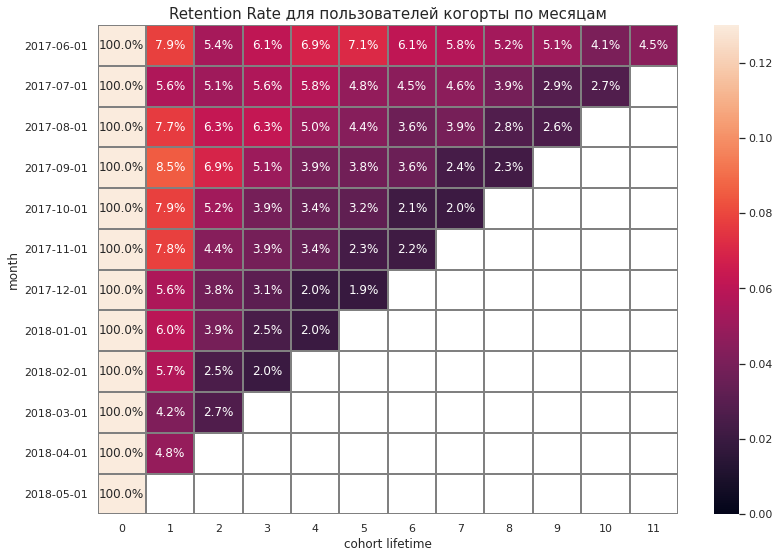

In [67]:
plot_heatmap(retention_table, '.1%', 'Retention Rate для пользователей когорты по месяцам', 
             'cohort lifetime', 'month', 0.13)

Процент повторных визитов невысок. Максимум 8,5%. Соответственно, низкий процент повторных заказов.  
Начиная с сентябрьской когорты в первую неделю retention rate заметно убывает с 8.5% до 4.2% в апреле.  
Также внутри каждой когорты снижение коэффициента удержания до 2% ускоряется. В первой когорте он снижается довольно медленно (относительно начального уровня на первой неделе жизни в 7.9% и не падает ниже 4%).  
Но если для второй когорты Retention Rate достиг 2% на 10 месяц жизни, то седьмая декабрьской когорта достигла 2% уже на четвертый месяц жизни.

#### Retention rate в зависимости от устройства

In [68]:
desktop_retention_table = \
create_retention_table(visits_data[visits_data['device'] == 'desktop'], 'start_ts', 'session_month', 'uid')

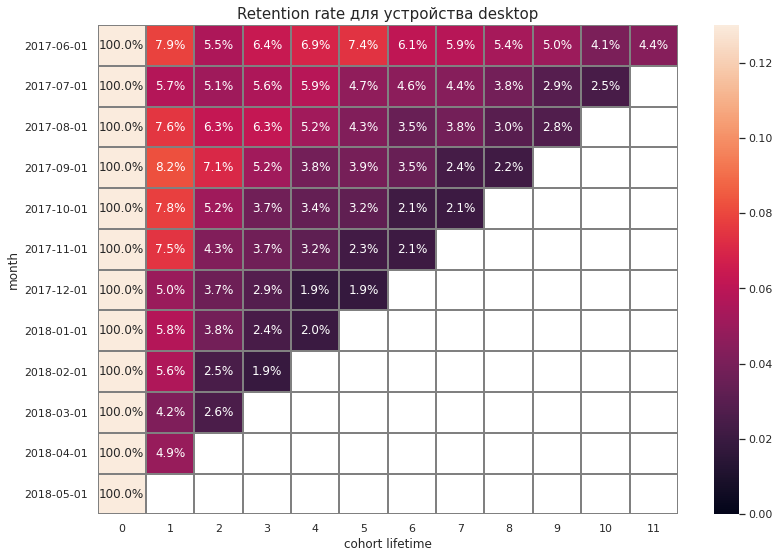

In [69]:
plot_heatmap(desktop_retention_table, '.1%', 'Retention rate для устройства desktop', 
             'cohort lifetime', 'month', 0.13)

In [70]:
touch_retention_table = \
create_retention_table(visits_data[visits_data['device'] == 'touch'], 'start_ts', 'session_month', 'uid')

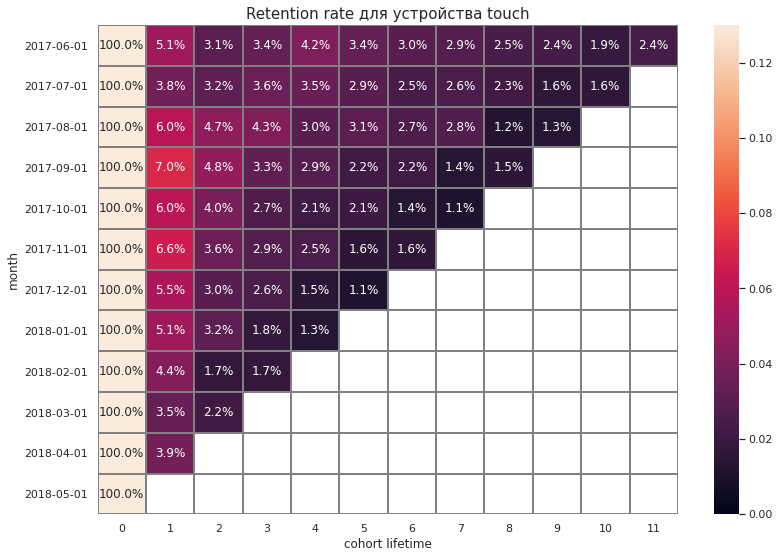

In [71]:
plot_heatmap(touch_retention_table,\
             '.1%','Retention rate для устройства touch', 'cohort lifetime', 'month', 0.13)

В таблице `touch` все показатели ниже в среднем на 1%, чем в таблице `desktop`. Пользователи с устройств `touch` возвращаются реже, чем пользователи устройств `desktop`.

#### Retention rate в зависимости от рекламного источника

Вспомним, как много посетителей приходит из разных источников.

In [72]:
visits_data['source_id'].value_counts()

4     101794
3      85609
5      66905
2      47626
1      34121
9      13276
10     10025
7         36
6          6
Name: source_id, dtype: int64

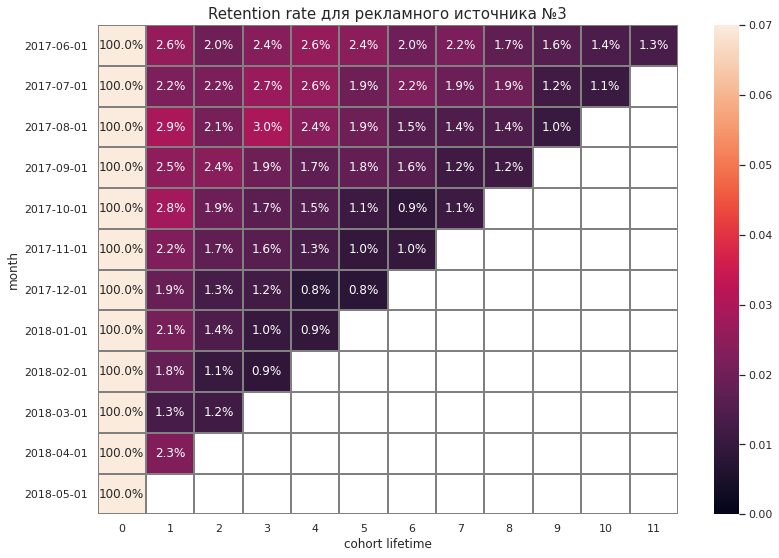

In [73]:
retention_source_3 = \
create_retention_table(visits_data[visits_data['source_id'] == 3], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_3, '.1%', 'Retention rate для рекламного источника №3', 
             'cohort lifetime', 'month', 0.07)

Источник №3 хоть и на втором месте по привлечению посетителей, но мало кто из них возвращается. Если во второй и третей когортах коэффициент удержания опускался до 1.9% через 5 месяцев, то в пятой когорте он уже на второй месяц жизни меньше 2%.

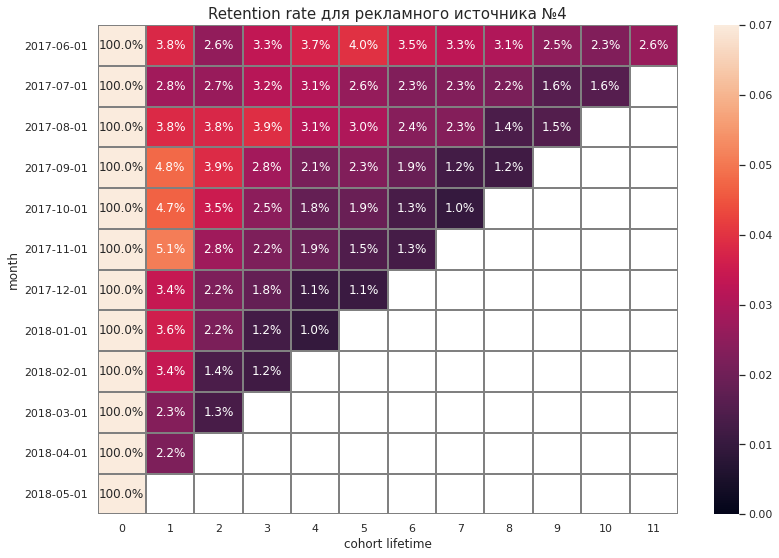

In [74]:
retention_source_4 = \
create_retention_table(visits_data[visits_data['source_id'] == 4], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_4, '.1%', 'Retention rate для рекламного источника №4', 
             'cohort lifetime', 'month', 0.07)

Источник №4 больше всех привлекает посетителей и показатели удержания у него выше. Посетители из первой когорты возвращаются чаще. И в первый месяц жизни когорт в октябре-ноябре был рост коэффициента.

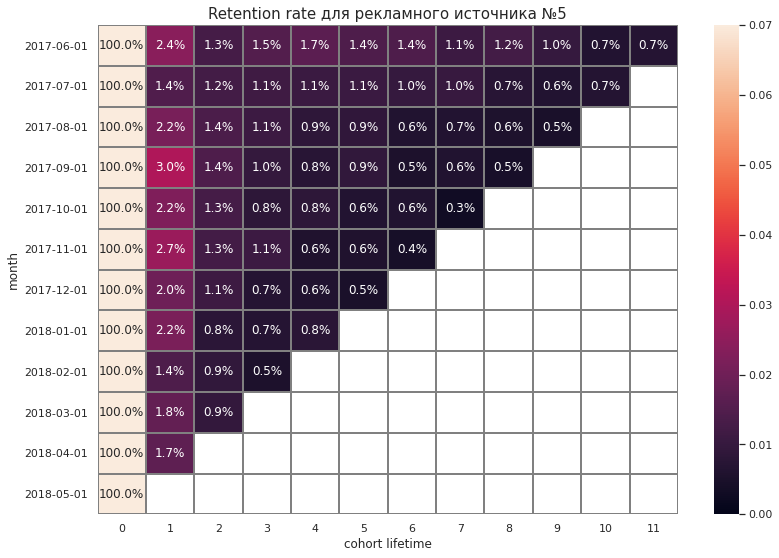

In [75]:
retention_source_5 = \
create_retention_table(visits_data[visits_data['source_id'] == 5], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_5, '.1%', 'Retention rate для рекламного источника №5', 
             'cohort lifetime', 'month', 0.07)

Пришедшие из источника 5 практически не возвращаются.

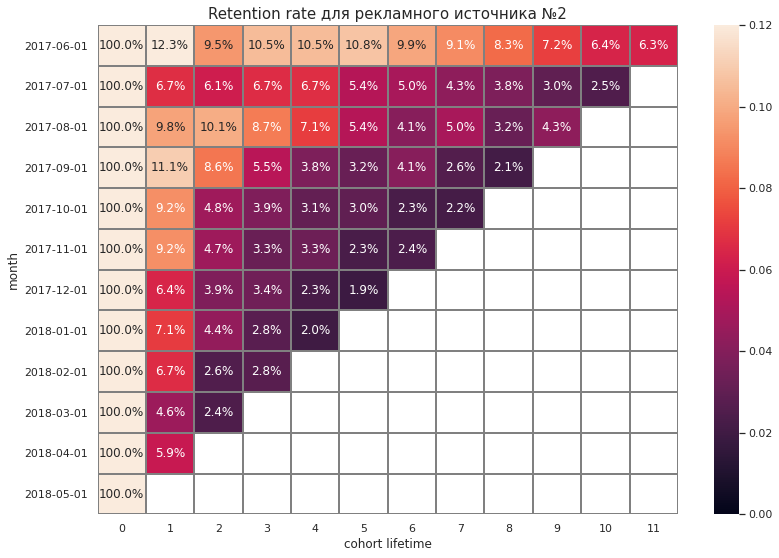

In [76]:
retention_source_2 = \
create_retention_table(visits_data[visits_data['source_id'] == 2], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_2, '.1%', 'Retention rate для рекламного источника №2', 
             'cohort lifetime', 'month', 0.12)

Наилучшие показатели из уже рассмотренных Retention Rate у источника №2.

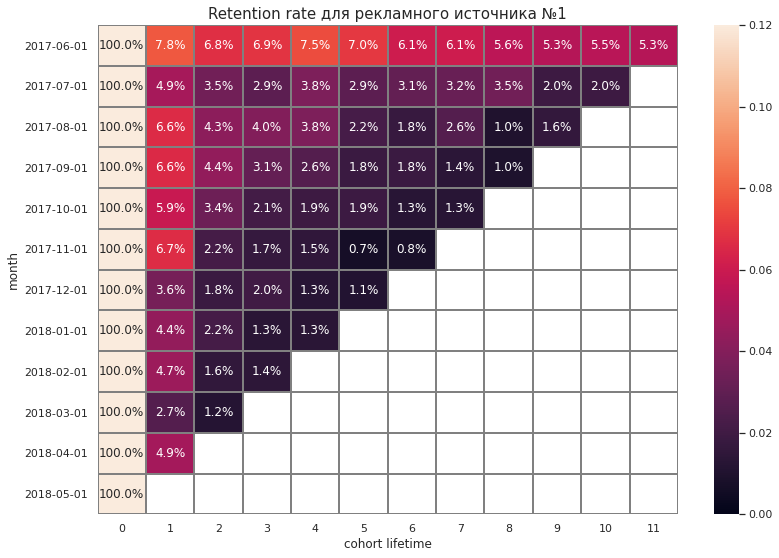

In [77]:
retention_source_1 = \
create_retention_table(visits_data[visits_data['source_id'] == 1], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_1, '.1%', 'Retention rate для рекламного источника №1', 
             'cohort lifetime', 'month', 0.12)

Только первая когорта возвращается с заметным постоянством, практически не убывает коэффициент со временем жизни когорты.

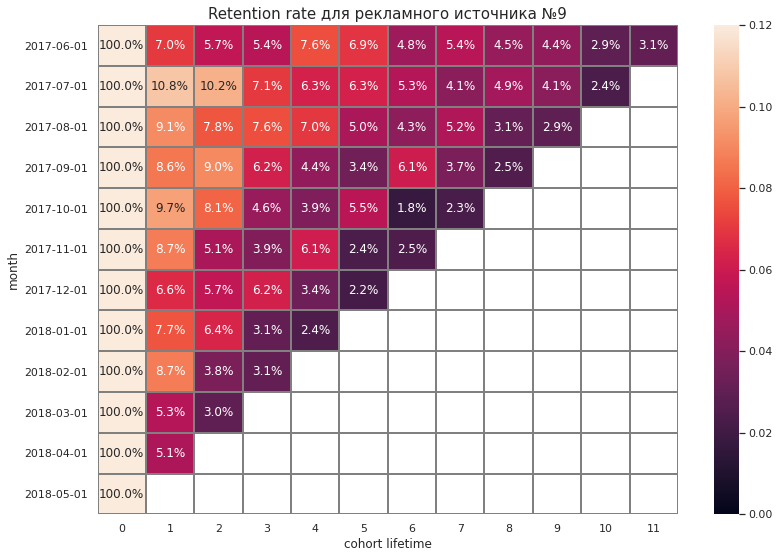

In [78]:
retention_source_9 = \
create_retention_table(visits_data[visits_data['source_id'] == 9], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_9, '.1%', 'Retention rate для рекламного источника №9', 
             'cohort lifetime', 'month', 0.12)

Хорошие показатели по сравнению с остальными источниками. Но с каждым месяцем в когортах быстрее падает коэффициент до 2 %. Во второй когорте на это потребовалось 10 месяцев. А в пятой уже на шестом месяце Retention Rate равен 1.8%.

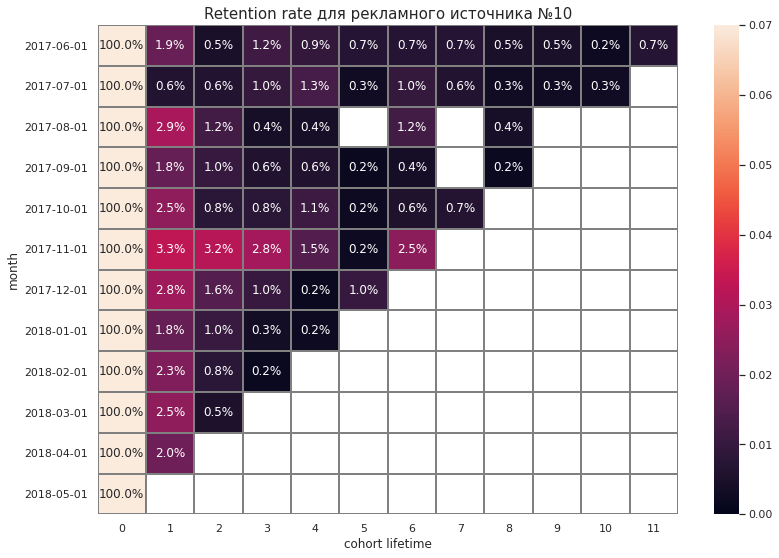

In [79]:
retention_source_10 = \
create_retention_table(visits_data[visits_data['source_id'] == 10], 'start_ts', 'session_month', 'uid')
plot_heatmap(retention_source_10, '.1%', 'Retention rate для рекламного источника №10', 
             'cohort lifetime', 'month', 0.07)

Самый большой процент вернувшихся заметен в ноябрьской когорте начиная с декабря в сезон новогодних каникул и праздничных мероприятий.

Лучшие результаты `Retention Rate` у источников 2 и 9. Худшие - у источников №3, 5 и 10.

### Продажи

### Когда люди начинают покупать    
Для начала рассчитаем, через сколько времени после первого посещения люди начинают делать заказ.

In [80]:
orders_data.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [81]:
first_visits = visits_data\
.groupby('uid')\
.agg(first_visits=('start_ts', 'min'))\
.reset_index()

In [82]:
first_orders = orders_data\
.groupby('uid')\
.agg(first_orders=('buy_ts', 'min'))\
.reset_index()

In [83]:
merged_data = first_visits.merge(first_orders, on='uid')

In [84]:
merged_data['period_to_buy'] = (merged_data['first_orders'] - merged_data['first_visits'])/np.timedelta64(1, 'm')

In [85]:
merged_data.head()

,uid,first_visits,first_orders,period_to_buy
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [86]:
merged_data['period_to_buy'].sort_values().value_counts()

1.0         2656
0.0         2455
2.0         2098
3.0         1685
4.0         1460
            ... 
157894.0       1
15698.0        1
95330.0        1
6896.0         1
344027.0       1
Name: period_to_buy, Length: 10561, dtype: int64

In [87]:
merged_data['period_to_buy'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: period_to_buy, dtype: float64

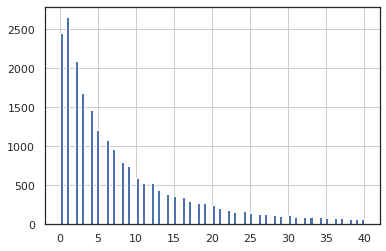

In [88]:
merged_data['period_to_buy'].hist(bins=100, range=(0, 40));

Половина посетителей совершают покупку в первые 16 минут от начала сессии. С увеличением времени уменьшается число пользователей, которым оно потребовалось на покупку. Если посетители не совершают покупку сразу, то до 75% успевают это сделать в течение двух дней после первой сессии.

Также можем посмотреть, в какую по счету сессию была совершена первая покупка.

#### Объединим датасеты с информацией о визитах и заказах, чтобы получить информацию о источниках и устройствах в заказах

In [89]:
first_sources = visits_data\
.sort_values('start_ts')\
.groupby('uid')[['device','source_id']]\
.first()\
.reset_index()\
.rename(columns={'uid':'uid', 'device':'first_device', 'source_id':'first_source'})

In [90]:
first_sources.head()

,uid,first_device,first_source
0,11863502262781,touch,3
1,49537067089222,touch,2
2,297729379853735,desktop,3
3,313578113262317,desktop,2
4,325320750514679,desktop,5


Добавим информацию об источниках и используемых устройствах в таблицу с заказами.

In [91]:
orders_data_new = orders_data.join(first_sources.set_index('uid'), on='uid')

Найдем номер сессии для каждого посетителя.

In [92]:
visits_data = visits_data.sort_values(['uid', 'start_ts'])
visits_data['sess_number'] = visits_data.groupby('uid').cumcount()+1

Выберем из таблицы с визитами только тех пользователей, которые совершали покупки.

In [93]:
orders_ids = orders_data['uid'].unique()
visits_from_orders = \
visits_data[visits_data['uid'].isin(orders_ids)][['start_ts', 'end_ts', 'device', 'source_id', 'uid', 'sess_number']]

Объединим таблицы с заказами и с визитами тех, кто делал заказ.

In [94]:
merged_df = pd.merge(orders_data, visits_from_orders, on='uid', left_index = True, how='left')

Создадим столбец-маркер, который будет показывать, был ли совершен заказ в конкретную сессию.

In [95]:
merged_df['is_order_session'] = (merged_df['buy_ts'] >= merged_df['start_ts']) &\
(merged_df['buy_ts'] <= merged_df['end_ts'])

Выберем только информацию о тех заказах, которые были совершены в конкретную сессию и мы точно знаем информацию о устройстве и рекламном источнике.

In [96]:
visits_with_orders = merged_df[merged_df['is_order_session']]

Объединим таблицу с информацией обо всех заказах с таблицей с заказами, совершенными в конкретную сессию.

In [97]:
orders_info = orders_data_new.merge(visits_with_orders, on=['uid', 'buy_ts'], how='outer')

In [98]:
orders_info.head()

,buy_ts,revenue_x,uid,first_device,first_source,revenue_y,start_ts,end_ts,device,source_id,sess_number,is_order_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,1,17.00,2017-06-01 00:09:00,2017-06-01 00:11:00,desktop,1.0,1.0,True
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2,0.55,2017-06-01 00:14:00,2017-06-01 00:25:00,desktop,2.0,1.0,True
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2,0.37,2017-06-01 00:25:00,2017-06-01 00:34:00,desktop,2.0,1.0,True
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2,0.55,2017-06-01 00:14:00,2017-06-01 00:33:00,desktop,2.0,1.0,True
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,3,0.37,2017-06-01 07:31:00,2017-06-01 07:59:00,desktop,3.0,1.0,True


Для тех заказов, о которых нет данных о сессии, а соответственно об устройстве и рекламном источнике, заполним пропуски значениями, взятыми из первой сессии данного посетителя.

In [99]:
orders_info['device'] = orders_info['device'].fillna(orders_info['first_device'])
orders_info['source_id'] = orders_info['source_id'].fillna(orders_info['first_source'])
orders_info = orders_info\
.drop(['first_device', 'first_source', 'revenue_y', 'start_ts', 'end_ts', 'is_order_session'], axis=1)

In [100]:
orders_info = orders_info.rename(columns={'revenue_x': 'revenue', 'order_month_x': 'order_month', 
                                         'order_month_y': 'order_month', 'order_date_y': 'order_date'})

In [101]:
orders_info['source_id'] = orders_info['source_id'].astype(int)
orders_info['sess_number'] = orders_info['sess_number'].fillna(0).astype(int)

In [102]:
orders_info.head()

,buy_ts,revenue,uid,device,source_id,sess_number
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,1,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,3,1


Найдем даты первых заказов для каждого пользователя.

In [103]:
first_purchases = orders_info.groupby('uid').agg(first_purchase = ('buy_ts', 'min'))

orders_info = orders_info.join(first_purchases, on='uid')
orders_info.sort_values(by='uid').head()

,buy_ts,revenue,uid,device,source_id,sess_number,first_purchase
27944,2018-01-03 21:51:00,0.55,313578113262317,desktop,2,0,2018-01-03 21:51:00
213,2017-06-03 10:13:00,1.22,1575281904278712,touch,10,1,2017-06-03 10:13:00
252,2017-06-03 17:39:00,1.83,1575281904278712,touch,10,2,2017-06-03 10:13:00
12235,2017-10-11 18:33:00,73.33,2429014661409475,desktop,3,0,2017-10-11 18:33:00
31462,2018-01-28 15:54:00,2.44,2464366381792757,desktop,5,0,2018-01-28 15:54:00


In [104]:
orders_info['sess_number'].value_counts()

1      21188
0      14488
2       7060
3       2525
4       1146
       ...  
598        1
534        1
202        1
470        1
255        1
Name: sess_number, Length: 283, dtype: int64

По всем значениям столбца видно, что покупки были не только в первую сессию. Но даже и на 255-ю.

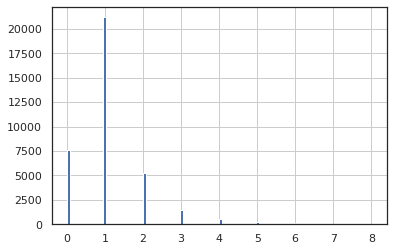

In [105]:
orders_info[orders_info['buy_ts'] == orders_info['first_purchase']]['sess_number'].hist(bins=100, range=(0, 8));

Большинство пользователей, совершивших покупку, делают это в первую же сессию.  
Значению 0 на графике соответствуют те заказы, для которых не известна точно сессия.

#### Номер сессии первой покупки в зависимости от устройства

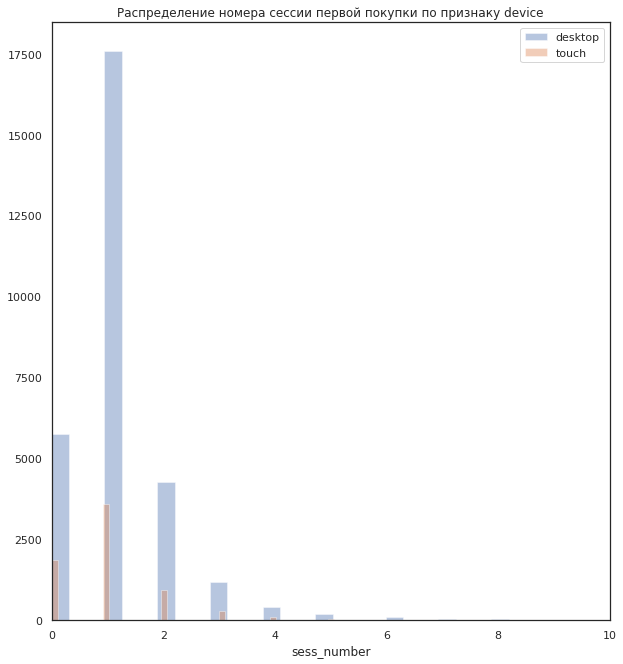

In [106]:
orders_info_grouped = orders_info[orders_info['buy_ts'] == orders_info['first_purchase']].groupby('device')

fig, axes = plt.subplots(1, 1, figsize=(10, 11))

for name, group in orders_info_grouped:
    sns.distplot(group['sess_number'].dropna(), kde=False, label=name, bins=200) 
    axes.set_xlim(0, 10)
    axes.legend()
    axes.set(title=f'Распределение номера сессии первой покупки по признаку device')

Устройство не влияет на номер сессии первой покупки. И на устройствах `desktop`, и на устройствах `touch` покупают в основном в первую сессию.

#### Номер сессии первой покупки в зависимости от рекламного источника

In [107]:
orders_info[orders_info['buy_ts'] == orders_info['first_purchase']].groupby('source_id')['sess_number'].describe()

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,4151.0,1.657914,1.966603,0.0,1.0,1.0,2.0,58.0
2,3835.0,1.398435,1.915889,0.0,1.0,1.0,2.0,56.0
3,9326.0,0.953678,1.171877,0.0,1.0,1.0,1.0,63.0
4,9730.0,1.046968,1.036468,0.0,1.0,1.0,1.0,24.0
5,7248.0,1.172875,0.999820,0.0,1.0,1.0,1.0,16.0
7,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
9,947.0,1.019007,1.298746,0.0,0.0,1.0,1.0,12.0
10,1285.0,1.045136,1.404649,0.0,1.0,1.0,1.0,42.0


Наибольшее число покупок было совершено из источников 3, 4 и 5. Из источников 7 и 9 было совсем мало заказов.  
Рекламный источник также не влияет на номер сессии первой покупки.

### Посчитаем конверсию посетителей в покупателей

In [108]:
visits_count = visits_data.groupby('session_month')['uid'].nunique()

In [109]:
orders_data['order_month'] = orders_data['buy_ts'].astype('datetime64[M]')
orders_count = orders_data.groupby('order_month')['uid'].nunique()

In [110]:
month_conversion = (orders_count/visits_count)

In [111]:
month_conversion

2017-06-01    0.152576
2017-07-01    0.139886
2017-08-01    0.126558
2017-09-01    0.144928
2017-10-01    0.157450
2017-11-01    0.138641
2017-12-01    0.156606
2018-01-01    0.135743
2018-02-01    0.148109
2018-03-01    0.152186
2018-04-01    0.130617
2018-05-01    0.171199
2018-06-01         NaN
Name: uid, dtype: float64

In [112]:
print('{:.2%}'.format(month_conversion.mean()))

14.62%


Достаточно высокая и стабильная конверсия в среднем в месяц около 15%.

###  Сколько раз покупают за период?
    

In [113]:
round(orders_data.shape[0]/orders_data['uid'].nunique(), 2)

1.38

В целом за весь рассматриваемый период почти не было повторных покупок. 

Рассчитаем точнее по когортам за период 6 месяцев.

In [114]:
def get_six_month_slice(cohorts):
    """
    Возвращает сгруппированную таблицу из когорт длиной жизни 6 месяцев
    """
    six_month_cohorts = cohorts[(cohorts['first_order_month'] < '2017-12-01') & (cohorts['lifetime'] <= 6)]
    six_month_cohorts_grouped = six_month_cohorts\
    .groupby('first_order_month')\
    .agg({'cohort_purchases_per_month': 'sum','n_buyers': 'mean'})\
    .eval('purchases_per_user = cohort_purchases_per_month / n_buyers')
    return six_month_cohorts_grouped

In [115]:
def create_month_cohort(df, month_col, groupby_col):
    """
    Возвращает таблицу с рассчитанными столбцами: месяц первой покупки,
    количество человек в когорте, сумму покупок внутри когорты в месяц,
    время жизни когорты, количество заказов в месяц.
    """
    data = df.copy()
    first_event = data.groupby(groupby_col).agg(first_order_month = (month_col, 'min')).reset_index()
    
    cohort_sizes = first_event.groupby('first_order_month')\
    .agg(n_buyers = (groupby_col, 'nunique')).reset_index()
    
    data_merged = pd.merge(data, first_event, on=groupby_col)
    
    cohorts = data_merged\
    .groupby(['first_order_month', month_col])\
    .agg(revenue = ('revenue', 'sum'), 
         cohort_purchases_per_month = (groupby_col, 'count'))\
    .reset_index()
    
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    # Рассчитаем возраст когорт
    report['lifetime'] = (report[month_col] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['lifetime'] = report['lifetime'].round().astype('int')

    return report

Посмотрим, сколько заказов совершается в когортах.  
Так как у нас данные до 1 июня 2018 года и в этот день был совершен заказ (только один), сформировалась когорта и на этот месяц. Не будем ее рассматривать.

In [116]:
cohorts = create_month_cohort(orders_data[:-1], 'order_month', 'uid')

In [117]:
cohorts.head()

,first_order_month,n_buyers,order_month,revenue,cohort_purchases_per_month,lifetime
0,2017-06-01,2023,2017-06-01,9557.49,2354,0
1,2017-06-01,2023,2017-07-01,981.82,177,1
2,2017-06-01,2023,2017-08-01,885.34,174,2
3,2017-06-01,2023,2017-09-01,1931.30,226,3
4,2017-06-01,2023,2017-10-01,2068.58,292,4


In [118]:
cohort_purchases_table = cohorts\
.pivot_table(index='first_order_month', columns='lifetime', values='cohort_purchases_per_month')

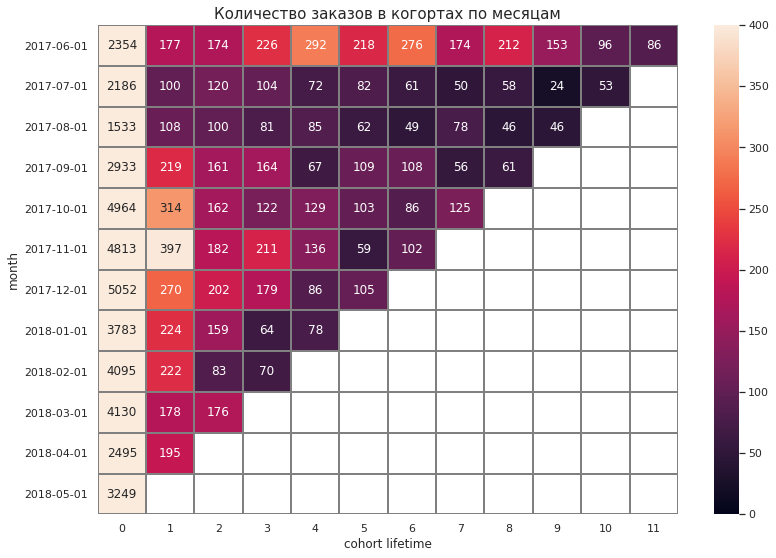

In [119]:
plot_heatmap(cohort_purchases_table, '.0f', 'Количество заказов в когортах по месяцам', 'cohort lifetime',
             'month', 400)

Наибольшее число заказов было в когорте декабря 2017 года. Но уже в первый месяц жизни в этой когорте было меньше заказов, чем в ноябрьской. Сильный рост покупок соответствует периоду повышения посещаемости с октября по март.  
В первой июньской когорте сохранается достаточно большое число заказов вплоть до марта. Но в каждой когорте с каждым месяцем жизни количество покупок убывает. Самый большой спад продаж уже на первом месяце жизни был в апрельской когорте.

Рассчитаем, сколько раз в среднем 1 человек в когорте покупает за период. Выберем в качестве периода 6 месяцев. Из 12 когорт у нас 6 просуществовали полгода. 

Сделаем срез данных по когортам, живущим 6 месяцев.

In [120]:
six_month_cohorts = get_six_month_slice(cohorts)
six_month_cohorts

,cohort_purchases_per_month,n_buyers,purchases_per_user
first_order_month,,,
2017-06-01,3717,2023,1.837370
2017-07-01,2725,1923,1.417057
2017-08-01,2018,1370,1.472993
2017-09-01,3761,2581,1.457187
2017-10-01,5880,4340,1.354839
2017-11-01,5900,4081,1.445724


In [121]:
six_month_cohorts['purchases_per_user'].mean().round()

1.0

Покупатели из первой когорты делали заказы за период 6 месяцев чаще остальных. Около двух покупок сделал в среднем каждый пользователь из первой когорты. В остальных когортах число покупок ближе к 1.  
Если смотреть на среднее число по всем когортам - то оно равно 1 покупке на каждого пользователя.  
То есть люди не возвращаются. Как видно из таблицы число заказов возрастает в сентябре-октябре, число покупателeй возрастает, но это новые покупатели, которые совершают в среднем 1 покупку за 6 месяцев.

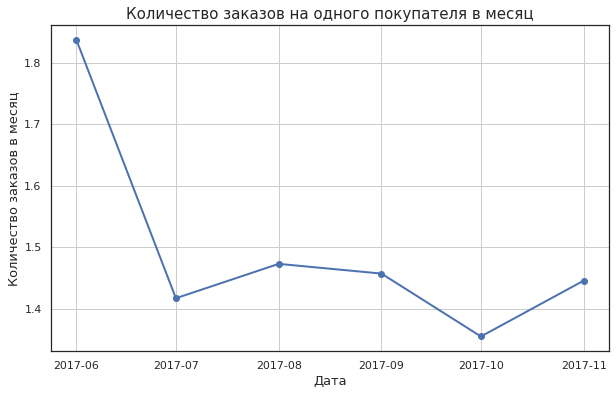

In [122]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(pd.to_datetime(six_month_cohorts.reset_index()['first_order_month']), 
          six_month_cohorts['purchases_per_user'], lw=2, marker='o')

axes.set_title('Количество заказов на одного покупателя в месяц', fontsize = 15)
axes.set_xlabel('Дата', fontsize = 13)
axes.set_ylabel('Количество заказов в месяц', fontsize = 13)
axes.grid(True)
plt.show()

Минимальное число заказов на 1 покупателя было в октябре. Далее оно должно расти, так как в этот период была высокая посещаемость сайта.

#### Сколько в среднем покупают за период в зависимости от устройства

Найдем месяц совершения заказа.

In [123]:
orders_info['order_month'] = orders_info['buy_ts'].astype('datetime64[M]')

Создадим когорты для клиентов с устройствами `desktop` и `touch`. Не будем брать в расчет последнюю строку датафрейма с информацией о единственном заказе в июне.

In [124]:
cohorts_desktop = create_month_cohort(orders_info[orders_info['device'] == 'desktop'][:-1], 'order_month', 'uid')
six_month_cohorts_desktop = get_six_month_slice(cohorts_desktop)

In [125]:
cohorts_touch = create_month_cohort(orders_info[orders_info['device'] == 'touch'][:-1], 'order_month', 'uid')
six_month_cohorts_touch = get_six_month_slice(cohorts_touch)

In [126]:
six_month_cohorts_desktop['purchases_per_user']\
.reset_index()\
.join(six_month_cohorts_touch['purchases_per_user'], on='first_order_month',lsuffix='_desktop', rsuffix='_touch')

,first_order_month,purchases_per_user_desktop,purchases_per_user_touch
0,2017-06-01,1.930894,1.192926
1,2017-07-01,1.414681,1.351706
2,2017-08-01,1.494709,1.296748
3,2017-09-01,1.441429,1.401590
4,2017-10-01,1.349391,1.296875
5,2017-11-01,1.435973,1.366391


In [127]:
six_month_cohorts_desktop['purchases_per_user']\
.reset_index()\
.join(six_month_cohorts_touch['purchases_per_user'], on='first_order_month',lsuffix='_desktop', rsuffix='_touch')\
.mean(axis=0)

purchases_per_user_desktop    1.511179
purchases_per_user_touch      1.317706
dtype: float64

В среднем по всем когортам за период 6 месяцев тип устройства слабо влияет на количество заказов на одного пользователя. На устройствах `desktop` значение чуть выше.

#### Сколько в среднем покупают за период в зависимости от рекламного источника

In [128]:
cohorts_per_source = orders_info[:-1].groupby('source_id').apply(create_month_cohort, 'order_month', 'uid')

In [129]:
six_month_cohorts_per_sources = cohorts_per_source[(cohorts_per_source['first_order_month'] < '2017-12-01') &\
                                                  (cohorts_per_source['lifetime'] <= 6)]

In [130]:
six_month_cohorts_grouped_source = six_month_cohorts_per_sources\
    .groupby(['source_id', 'first_order_month'])\
    .agg({'cohort_purchases_per_month': 'sum','n_buyers': 'mean'})\
    .eval('purchases_per_user = cohort_purchases_per_month / n_buyers')

In [131]:
six_month_cohorts_grouped_source.pivot_table(index='source_id', columns='first_order_month', values='purchases_per_user')

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01
source_id,,,,,,
1,2.790441,1.266667,2.017647,1.299145,1.280835,1.338954
2,1.771536,1.665354,1.480263,1.823529,1.467456,1.647059
3,1.159869,1.176715,1.133956,1.207042,1.166215,1.200000
4,1.219753,1.202020,1.263610,1.214890,1.214041,1.270782
5,1.813268,1.323789,1.613699,1.259720,1.207129,1.204330
7,NaN,NaN,1.000000,NaN,NaN,NaN
9,1.419355,1.480000,1.779661,1.447059,1.263158,1.282353
10,1.118280,1.075472,1.097561,1.176471,1.079208,1.271318


In [132]:
six_month_cohorts_grouped_source\
.pivot_table(index='source_id', columns='first_order_month', values='purchases_per_user')\
.mean(axis=1)

source_id
1     1.665615
2     1.642533
3     1.173966
4     1.230849
5     1.403656
7     1.000000
9     1.445264
10    1.136385
dtype: float64

Из источников 1 и 2 покупок было чуть больше в пересчете на одного пользователя за 6 месяцев.

Посмотрим в дополнение к рассуждениям выше количество заказов в месяц по рекламным источникам.

In [133]:
orders_info.pivot_table(index='order_month', columns='source_id', values='uid', aggfunc='count')

source_id,1,2,3,4,5,7,9,10
order_month,,,,,,,,
2017-06-01,326.0,308.0,646.0,440.0,463.0,NaN,68.0,103.0
2017-07-01,333.0,318.0,514.0,538.0,551.0,NaN,55.0,54.0
2017-08-01,265.0,209.0,358.0,389.0,464.0,1.0,77.0,44.0
2017-09-01,514.0,423.0,789.0,652.0,809.0,NaN,109.0,91.0
2017-10-01,724.0,736.0,1249.0,1333.0,1251.0,NaN,169.0,217.0
2017-11-01,818.0,779.0,1322.0,1433.0,927.0,NaN,230.0,150.0
2017-12-01,896.0,868.0,1442.0,1674.0,1094.0,NaN,145.0,99.0
2018-01-01,626.0,623.0,1081.0,1258.0,903.0,NaN,131.0,99.0
2018-02-01,690.0,712.0,1214.0,1353.0,1039.0,NaN,123.0,150.0


Больше всего заказов приходит из источников 3 и 4.

### Рассчитаем средний чек покупателя

In [134]:
average_check = orders_data['revenue'].mean()
average_check.round(2)

5.0

В среднем 5 рублей - столько тратит пользователь за одну покупку.


Посмотрим как менялась выручка по дням на графике.

In [135]:
orders_data['order_date'] = orders_data['buy_ts'].dt.date

In [136]:
revenue_per_day = orders_data\
.groupby('order_date')\
.agg(orders_count = ('uid', 'count'), total_revenue = ('revenue', 'sum'))\
.assign(mean_day_revenue = lambda x: x['total_revenue']/x['orders_count'])\
.reset_index()

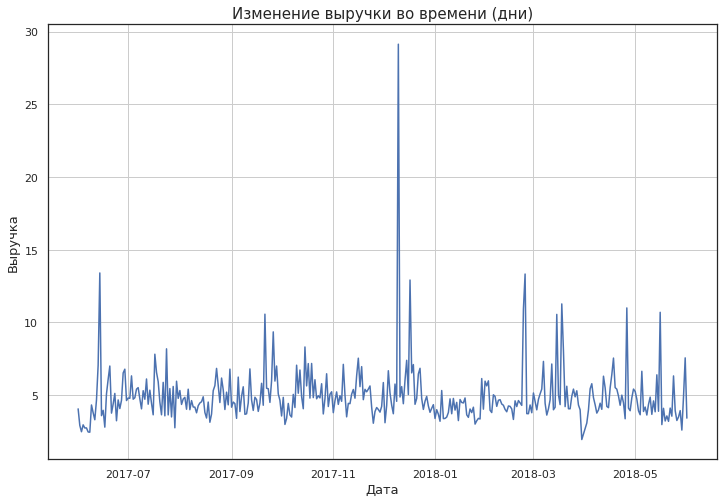

In [137]:
fig, ax = plt.subplots(figsize=(12,8))

ax.set_xlabel('Дата', fontsize=13)
ax.set_ylabel('Выручка', fontsize=13)
ax.set_title('Изменение выручки во времени (дни)', fontsize = 15)
ax.grid(True)
ax.plot(pd.to_datetime(revenue_per_day['order_date']), revenue_per_day['mean_day_revenue'])
plt.show()

In [138]:
revenue_per_day[revenue_per_day['mean_day_revenue'] == revenue_per_day['mean_day_revenue'].max()]['order_date']

192    2017-12-10
Name: order_date, dtype: object

In [139]:
revenue_per_day['mean_day_revenue'].describe()

count    364.000000
mean       4.936188
std        2.021881
min        1.948000
25%        3.960635
50%        4.561548
75%        5.411037
max       29.133313
Name: mean_day_revenue, dtype: float64

Средний чек равен 5 рублей. В статистике по дням средний чек не сильно отличается. Отклонение от среднего равно 2 рубля.  
По графику виден ярко выраженный пик выручки - 12 декабря 2017 года. Возможно, это связано с покупкой билетов на  новогодние мероприятия.  

#### Средний чек покупателя в зависимости от устройства

In [140]:
orders_info.groupby('device')['revenue'].mean()

device
desktop    5.165085
touch      4.226889
Name: revenue, dtype: float64

Средний чек на устройствах `desktop` выше на 1 рубль, чем на устройствах `touch`.

#### Средний чек покупателя в зависимости от рекламного источника

In [141]:
orders_info.groupby('source_id')['revenue'].mean()

source_id
1     5.831636
2     7.718839
3     4.012297
4     4.227530
5     5.182497
7     1.220000
9     3.383200
10    2.750670
Name: revenue, dtype: float64

Самый большой средний чек у источника 2. Источники 1, 3, 4 и 5 колеблются с разницей в 1 рубль. Сильно проседают источники 7, 9, 10.

###    Рассчитаем сколько денег приносят покупатели  
  
Возьмем наш датафрейм с когортами по месяцам, примем маржинальность за 1 и найдем LTV.

In [142]:
cohorts.head()

,first_order_month,n_buyers,order_month,revenue,cohort_purchases_per_month,lifetime
0,2017-06-01,2023,2017-06-01,9557.49,2354,0
1,2017-06-01,2023,2017-07-01,981.82,177,1
2,2017-06-01,2023,2017-08-01,885.34,174,2
3,2017-06-01,2023,2017-09-01,1931.30,226,3
4,2017-06-01,2023,2017-10-01,2068.58,292,4


In [143]:
cohorts['ltv'] = cohorts['revenue'] / cohorts['n_buyers']

In [144]:
output = cohorts\
.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='ltv')\
.cumsum(axis=1)\
.fillna(0)\
.round(2)

In [145]:
output

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,0.00
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,0.00,0.00
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,0.00,0.00,0.00
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,0.00,0.00,0.00,0.00
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,4.14,4.43,4.73,4.88,4.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,4.16,4.44,4.51,4.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


В среднем каждый покупатель из первой когорты принес по 11.88 рублей выручки за год использования сайта.  
Максимальную сумму принесли покупатели сентябрьской когорты - 13.43 рубля за 9 месяцев. 

Сравним когорты, о которых есть информация за период 6 месяцев.

In [146]:
output.loc[:'2017-11-01', 0:6]

lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40


В каждой `LTV` растет с увеличением "времени жизни" когорты. Но скорость роста разная. Быстрее всего растут значения сентябрьской и июньской когорт.  
Значения на нулевой период жизни по когортам не сильно отличаются. 

#### Сколько денег приносят покупатели в зависимости от устройства

In [147]:
cohorts_desktop['ltv'] = cohorts_desktop['revenue'] / cohorts_desktop['n_buyers']
output_desktop = cohorts_desktop\
.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='ltv')\
.cumsum(axis=1)\
.fillna(0)\
.round(2)
output_desktop

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.90,5.41,5.89,7.01,8.18,9.04,10.14,10.82,11.46,12.14,12.79,13.05
2017-07-01,6.12,6.47,7.23,7.55,7.72,7.88,8.01,8.15,8.32,8.49,8.65,0.00
2017-08-01,5.32,5.86,6.39,6.83,7.41,7.71,7.93,8.39,8.73,8.94,0.00,0.00
2017-09-01,5.85,6.76,7.14,11.91,12.39,13.13,13.64,13.88,14.09,0.00,0.00,0.00
2017-10-01,5.13,5.66,5.86,6.04,6.19,6.39,6.49,6.61,0.00,0.00,0.00,0.00
2017-11-01,4.98,5.39,5.61,5.98,6.12,6.18,6.31,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.85,5.13,6.24,7.52,7.90,8.30,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,4.20,4.54,4.89,5.05,5.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,4.22,4.49,4.58,4.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [148]:
cohorts_touch['ltv'] = cohorts_touch['revenue'] / cohorts_touch['n_buyers']
output_touch = cohorts_touch\
.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='ltv')\
.cumsum(axis=1)\
.fillna(0)\
.round(2)
output_touch

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,3.60,3.92,4.05,4.08,4.20,4.24,4.24,0.00,4.27,4.40,4.42,4.66
2017-07-01,5.43,5.65,5.69,5.94,6.11,6.26,6.31,6.40,6.43,6.47,6.59,0.00
2017-08-01,4.91,5.04,5.14,5.19,5.22,5.42,5.55,5.65,5.71,5.76,0.00,0.00
2017-09-01,4.56,6.11,6.88,7.35,7.40,7.57,8.42,8.69,8.73,0.00,0.00,0.00
2017-10-01,4.55,5.13,5.21,5.24,5.29,5.39,5.41,5.44,0.00,0.00,0.00,0.00
2017-11-01,5.93,6.09,6.14,6.21,6.29,6.29,6.32,0.00,0.00,0.00,0.00,0.00
2017-12-01,4.09,4.24,4.35,4.48,4.49,4.51,0.00,0.00,0.00,0.00,0.00,0.00
2018-01-01,3.77,3.85,3.88,3.94,3.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-02-01,3.86,3.99,4.02,4.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


В основном, пользователи устройства `desktop` приносят больше денег. До декабря здесь сохраняются большие суммы. Но начиная с марта значения `ltv` по устройствам уже не сильно отличаются и колеблются около значения среднего чека.

Посмотрим вместе итоговый `LTV` когорт за период 6 месяцев в зависимости от типа устройства.  

In [149]:
display(output_desktop.loc[:'2017-11-01', 0:6])
display(output_touch.loc[:'2017-11-01', 0:6])

lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.90,5.41,5.89,7.01,8.18,9.04,10.14
2017-07-01,6.12,6.47,7.23,7.55,7.72,7.88,8.01
2017-08-01,5.32,5.86,6.39,6.83,7.41,7.71,7.93
2017-09-01,5.85,6.76,7.14,11.91,12.39,13.13,13.64
2017-10-01,5.13,5.66,5.86,6.04,6.19,6.39,6.49
2017-11-01,4.98,5.39,5.61,5.98,6.12,6.18,6.31


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,3.60,3.92,4.05,4.08,4.20,4.24,4.24
2017-07-01,5.43,5.65,5.69,5.94,6.11,6.26,6.31
2017-08-01,4.91,5.04,5.14,5.19,5.22,5.42,5.55
2017-09-01,4.56,6.11,6.88,7.35,7.40,7.57,8.42
2017-10-01,4.55,5.13,5.21,5.24,5.29,5.39,5.41
2017-11-01,5.93,6.09,6.14,6.21,6.29,6.29,6.32


In [150]:
output_desktop.loc[:'2017-11-01', 0:6].iloc[:,-1:]\
.join(output_touch.loc[:'2017-11-01', 0:6].iloc[:,-1:], lsuffix='_desktop', rsuffix='_touch')

lifetime,6_desktop,6_touch
first_order_month,,
2017-06-01,10.14,4.24
2017-07-01,8.01,6.31
2017-08-01,7.93,5.55
2017-09-01,13.64,8.42
2017-10-01,6.49,5.41
2017-11-01,6.31,6.32


`LTV` пользователей устройств `touch` в основном ниже, чем пользователей устройств `desktop`. Только  в ноябрьской когорте значения для разных устройств были сопоставимы.

#### Сколько денег приносят покупатели в зависимости от рекламного источника

In [151]:
cohorts_per_source.head()

first_order_month  n_buyers order_month  revenue  \
source_id                                                      
1         0        2017-06-01       272  2017-06-01  1557.89   
          1        2017-06-01       272  2017-07-01   259.15   
          2        2017-06-01       272  2017-08-01   284.53   
          3        2017-06-01       272  2017-09-01   416.33   
          4        2017-06-01       272  2017-10-01   669.28   

             cohort_purchases_per_month  lifetime  
source_id                                          
1         0                         326         0  
          1                          57         1  
          2                          56         2  
          3                          82         3  
          4                          82         4

In [152]:
cohorts_per_source['ltv'] = cohorts_per_source['revenue'] / cohorts_per_source['n_buyers']

In [153]:
ltv_per_source = cohorts_per_source[(cohorts_per_source['first_order_month'] <= pd.to_datetime('2017-11-01')) &
                               (cohorts_per_source['lifetime'] <= 6)].drop(7)

In [154]:
for name, group in ltv_per_source.groupby('source_id'):
    
    cohort_source_table = group\
    .pivot_table(
        index='first_order_month', 
        columns='lifetime', 
        values='ltv')\
    .cumsum(axis=1)\
    .fillna(0)\
    .round(2)
    print ('\033[1m' + f'Источник {name}' + '\033[0m')
    display(cohort_source_table)

Источник 1


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,5.73,6.68,7.73,9.26,11.72,13.22,16.07
2017-07-01,7.37,7.86,10.26,10.86,11.09,11.31,11.39
2017-08-01,6.73,8.45,9.08,9.77,10.71,11.40,12.31
2017-09-01,5.76,6.27,6.66,7.26,7.71,7.76,7.80
2017-10-01,6.13,6.77,7.00,7.28,7.42,8.11,8.23
2017-11-01,6.33,6.76,7.04,7.55,7.61,7.69,8.09


Источник 2


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,6.32,6.82,7.00,8.64,9.92,10.51,11.68
2017-07-01,7.68,8.36,8.52,8.79,9.20,9.70,10.13
2017-08-01,4.95,5.99,6.33,6.61,7.02,7.13,7.27
2017-09-01,7.67,13.64,15.32,15.95,16.67,17.16,19.20
2017-10-01,6.89,8.57,9.04,9.38,9.63,9.74,9.82
2017-11-01,6.34,14.41,15.41,16.56,16.80,17.01,17.10


Источник 3


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,3.42,3.47,3.59,3.75,3.89,4.00,4.10
2017-07-01,5.51,5.73,5.82,6.00,6.03,6.10,6.12
2017-08-01,4.89,5.02,5.28,5.38,5.41,5.44,5.49
2017-09-01,5.17,5.25,5.29,5.41,5.47,5.54,5.63
2017-10-01,4.25,4.45,4.53,4.54,4.59,4.64,4.65
2017-11-01,4.61,4.70,4.76,4.85,4.89,4.91,4.93


Источник 4


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.45,4.46,4.54,4.63,5.46,5.84,6.18
2017-07-01,5.37,5.41,5.46,5.63,5.66,5.74,5.83
2017-08-01,4.92,5.34,5.59,6.73,6.85,7.01,7.14
2017-09-01,4.50,4.85,5.01,5.28,5.33,5.56,6.31
2017-10-01,4.26,4.38,4.48,4.57,4.66,4.74,4.81
2017-11-01,4.67,5.12,5.18,5.50,5.65,5.68,5.76


Источник 5


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.93,5.73,6.09,7.41,8.06,8.48,9.15
2017-07-01,5.04,5.54,5.86,6.09,6.22,6.32,6.36
2017-08-01,5.26,5.76,6.60,7.19,8.24,8.81,9.14
2017-09-01,5.98,6.11,6.25,14.57,14.71,15.87,16.10
2017-10-01,5.00,5.08,5.15,5.24,5.36,5.45,5.57
2017-11-01,4.47,4.61,4.69,4.71,4.85,4.87,4.97


Источник 9


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,3.36,3.40,3.88,4.10,4.30,4.40,4.47
2017-07-01,4.21,4.31,4.60,4.71,4.86,4.91,5.21
2017-08-01,3.42,3.82,4.37,4.79,4.79,4.85,5.03
2017-09-01,3.95,4.39,4.83,5.13,5.43,5.55,5.64
2017-10-01,4.38,4.71,5.06,5.14,5.32,0.00,5.33
2017-11-01,3.44,3.49,3.56,3.74,3.80,3.82,3.84


Источник 10


lifetime,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,2.15,2.16,0.00,0.00,0.00,0.00,0.00
2017-07-01,2.70,2.73,0.00,2.88,0.00,0.00,0.00
2017-08-01,4.58,4.68,4.71,0.00,0.00,0.00,0.00
2017-09-01,2.24,2.27,2.36,2.54,2.56,0.00,0.00
2017-10-01,2.57,2.64,0.00,2.66,2.66,2.67,2.69
2017-11-01,3.93,3.98,4.00,4.10,4.20,4.21,4.24


Больше всего денег приносят покупатели из источников №1, 2 и 5.  
В результатах `LTV` для остальных источников в основном каждый пользователь в среднем за рассматриваемый период приносит сумму, приблизительно равную среднему чеку, так как повторных покупок практически нет.

### Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

In [155]:
costs_data['costs'].sum()

329131.62

Всего потрачено 329131.62 рублей.

#### Сколько потрачено денег в зависимости от источника расходов

In [156]:
costs_data.pivot_table(index='source_id', values='costs', aggfunc='sum')

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Больше всего средств потрачено на рекламный источник 3.

#### Посмотрим на распределение расходов во времени

In [157]:
dayly_costs = costs_data.groupby('dt')['costs'].sum().reset_index()

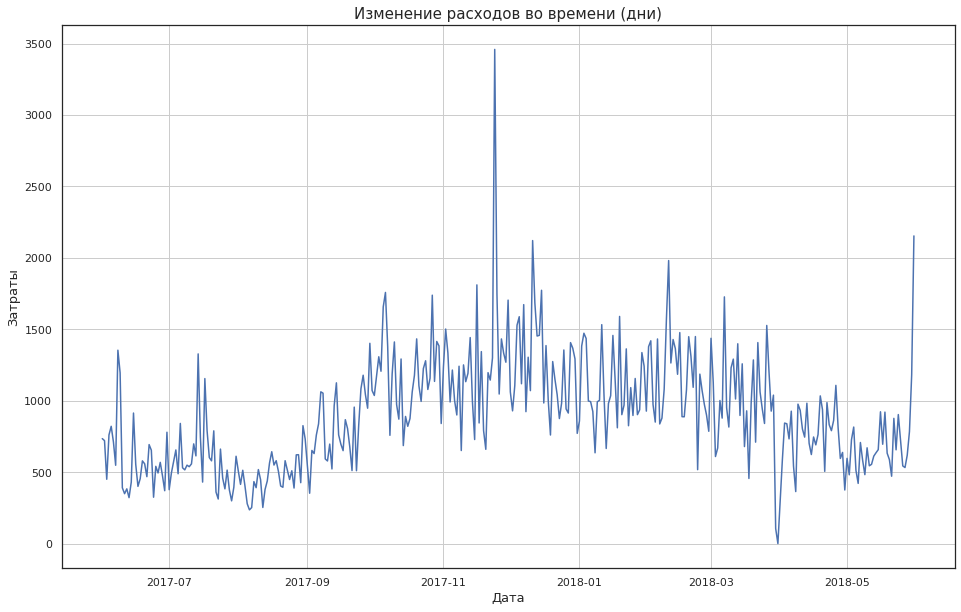

In [158]:
fig, ax = plt.subplots(figsize=(16,10))

ax.set_xlabel('Дата', fontsize=13)
ax.set_ylabel('Затраты', fontsize=13)
ax.set_title('Изменение расходов во времени (дни)', fontsize = 15)
ax.grid(True)
ax.plot(dayly_costs['dt'], dayly_costs['costs'])
plt.show()

In [159]:
dayly_costs[dayly_costs['costs'] == dayly_costs['costs'].max()]['dt']

176   2017-11-24
Name: dt, dtype: datetime64[ns]

In [160]:
dayly_costs['costs'].describe()

count     364.000000
mean      904.207747
std       396.956825
min         0.700000
25%       595.682500
50%       873.655000
75%      1155.605000
max      3458.860000
Name: costs, dtype: float64

In [161]:
costs_data['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Затраты возрастают с октября 2017 по апрель 2018 года. Максимальная сумма была потрачена 24 ноября 2017 (перед максимальным чеком, полученным 10 декабря).

### Сколько стоило привлечение одного покупателя из каждого источника?

In [162]:
costs_data['month'] = costs_data['dt'].astype('datetime64[M]')
monthly_costs = costs_data.groupby(['source_id', 'month'])['costs'].sum()

In [163]:
monthly_costs = monthly_costs.reset_index().set_index('source_id')
monthly_costs.head()

,month,costs
source_id,,
1,2017-06-01,1125.61
1,2017-07-01,1072.88
1,2017-08-01,951.81
1,2017-09-01,1502.01
1,2017-10-01,2315.75


Сначала сравним общие итоговые значения `LTV` и `CAC` для первой когорты.

In [164]:
ltv_201706 = output.loc['2017-06-01', 11]
ltv_201706

11.88

In [165]:
monthly_costs[monthly_costs['month'] == '2017-06-01']

,month,costs
source_id,,
1,2017-06-01,1125.61
2,2017-06-01,2427.38
3,2017-06-01,7731.65
4,2017-06-01,3514.80
5,2017-06-01,2616.12
9,2017-06-01,285.22
10,2017-06-01,314.22


In [166]:
costs_201706 = monthly_costs[monthly_costs['month'] == '2017-06-01']['costs'].sum()
costs_201706

18015.0

In [167]:
cohort_201706 = cohorts[cohorts['first_order_month'] == pd.to_datetime('2017-06-01')]

In [168]:
n_buyers_201706 = cohort_201706['n_buyers'][0]
n_buyers_201706

2023

In [169]:
cac_201706 = costs_201706 / n_buyers_201706
cac_201706

8.905091448344043

In [170]:
print('CAC =', round(cac_201706, 2))
print('LTV =', ltv_201706)

CAC = 8.91
LTV = 11.88


`LTV` больше `CAC`, значит, для первой когорты окупились затраты на привлечение покупателей.

Рассмотрим теперь расходы на привлечение одного покупателя для каждого источника.  
Объединим таблицы с рассчитанным `LTV` и помесячными затратами.

In [171]:
cohorts_per_source_metrics = monthly_costs.reset_index()\
.merge(cohorts_per_source.reset_index().drop(columns=['level_1']), 
       how='outer', right_on=['source_id', 'first_order_month'], left_on=['source_id','month'])

In [172]:
cohorts_per_source_metrics['cac'] = cohorts_per_source_metrics['costs'] / cohorts_per_source_metrics['n_buyers']

In [173]:
cohorts_per_source_metrics

,source_id,month,costs,first_order_month,n_buyers,order_month,revenue,cohort_purchases_per_month,lifetime,ltv,cac
0,1,2017-06-01,1125.61,2017-06-01,272,2017-06-01,1557.89,326,0,5.727537,4.138272
1,1,2017-06-01,1125.61,2017-06-01,272,2017-07-01,259.15,57,1,0.952757,4.138272
2,1,2017-06-01,1125.61,2017-06-01,272,2017-08-01,284.53,56,2,1.046066,4.138272
3,1,2017-06-01,1125.61,2017-06-01,272,2017-09-01,416.33,82,3,1.530625,4.138272
4,1,2017-06-01,1125.61,2017-06-01,272,2017-10-01,669.28,82,4,2.460588,4.138272
...,...,...,...,...,...,...,...,...,...,...,...
497,10,2018-03-01,526.41,2018-03-01,189,2018-04-01,11.79,4,1,0.062381,2.785238
498,10,2018-03-01,526.41,2018-03-01,189,2018-05-01,0.30,1,2,0.001587,2.785238
499,10,2018-04-01,388.25,2018-04-01,113,2018-04-01,269.41,118,0,2.384159,3.435841
500,10,2018-05-01,409.86,2018-05-01,129,2018-05-01,456.54,141,0,3.539070,3.177209


Для пары строк не было информации о расходах. Удалим пропуски.

In [174]:
cohorts_per_source_metrics = cohorts_per_source_metrics.dropna().copy()

In [175]:
cohorts_per_source_metrics['cac'] = cohorts_per_source_metrics['costs'] / cohorts_per_source_metrics['n_buyers']

In [176]:
output_source_cac = pd.DataFrame()
for name, group in cohorts_per_source_metrics.groupby('source_id'):
    
    cohort_source_table_cac = group\
    .pivot_table(
        index='first_order_month', 
        values='cac',
    aggfunc='mean')\
    .round(2)
    
    output_source_cac[name] = cohort_source_table_cac['cac']

In [177]:
output_source_cac

,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,4.14,9.09,12.61,8.68,6.43,4.60,3.38
2017-07-01,4.21,9.19,15.96,7.13,6.60,6.05,6.22
2017-08-01,5.60,11.91,19.14,9.22,5.99,4.22,5.67
2017-09-01,4.28,9.76,14.03,8.79,5.99,4.89,5.42
2017-10-01,4.39,9.56,14.22,5.50,5.56,4.58,3.11
2017-11-01,4.12,9.96,14.87,4.44,8.56,4.02,6.14
2017-12-01,3.70,9.19,12.90,5.47,7.20,5.44,7.69
2018-01-01,5.12,11.68,15.60,5.53,7.50,5.64,6.75
2018-02-01,4.86,11.30,13.67,5.06,6.44,6.20,3.54


Посмотрим сколько в среднем за год стоило привлечение одного клиента для разных источников.

In [178]:
output_source_cac.mean()

1      4.389167
2      9.785833
3     14.520833
4      6.392500
5      6.648333
9      5.182500
10     4.777500
dtype: float64

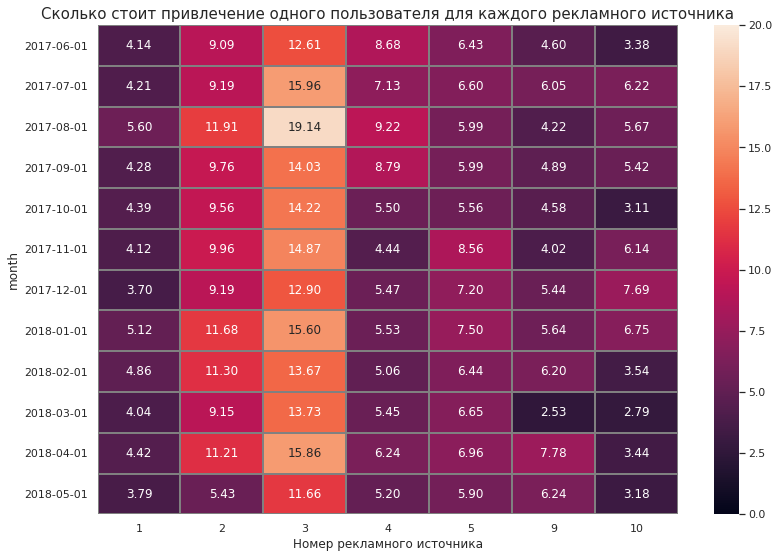

In [179]:
plot_heatmap(output_source_cac, '.2f', 
             'Сколько стоит привлечение одного пользователя для каждого рекламного источника', 
             'Номер рекламного источника', 'month', 20)

Больше всего денег тратится на привлечение людей из источника 3 и 2.  
Максимальное значение вложений в источник №3 было в августе 2017 года и равно 19.14 рублей на привлечение одного пользователя. Далее оно снижается, но не опускается ниже 11.66 рублей.  
Максимальная сумма за привлечение одного клиента с источника №2 равна 11.91 рублей. На протяжении почти всего года расходы не опускались ниже 9 рублей. И только в мае резко упали до 5.43 рубля.  
На источник №4 летом и в сентябре 2017 года тратили в среднем 8.5 рублей, но с октября траты снизились до 5.5 рублей и далее оставались в этих пределах.  
А вот на источник №5 начали тратить больше начиная с ноября 2017 года.
На источники №1 среднем тратили примерно одинаково.  
Траты на источник №9 в основном начали расти с декабря 2017 года. А вот вложения в источник № 10 наоборот, начали уменьшаться с февраля 2018 года.

### На сколько окупились расходы? (ROMI)

In [180]:
cohorts_per_source_metrics['romi'] = cohorts_per_source_metrics['ltv'] / cohorts_per_source_metrics['cac']

In [181]:
cohorts_per_source_metrics.head()

,source_id,month,costs,first_order_month,n_buyers,order_month,revenue,cohort_purchases_per_month,lifetime,ltv,cac,romi
0,1,2017-06-01,1125.61,2017-06-01,272,2017-06-01,1557.89,326,0,5.727537,4.138272,1.384041
1,1,2017-06-01,1125.61,2017-06-01,272,2017-07-01,259.15,57,1,0.952757,4.138272,0.230231
2,1,2017-06-01,1125.61,2017-06-01,272,2017-08-01,284.53,56,2,1.046066,4.138272,0.252778
3,1,2017-06-01,1125.61,2017-06-01,272,2017-09-01,416.33,82,3,1.530625,4.138272,0.369871
4,1,2017-06-01,1125.61,2017-06-01,272,2017-10-01,669.28,82,4,2.460588,4.138272,0.594593


In [182]:
output_source_romi = pd.DataFrame(index=range(0,12))
for name, group in cohorts_per_source_metrics.groupby('source_id'):
    
    cohorts_per_source_romi = group\
    .pivot_table(
        index='first_order_month', 
        columns='lifetime',\
        values='romi',
    aggfunc='mean')\
    .fillna(0)\
    .cumsum(axis=1)\
    .mean(axis=0)
    
    output_source_romi[name] = cohorts_per_source_romi
  

In [183]:
output_source_romi

,1,2,3,4,5,9,10
0,1.308131,0.665272,0.298822,0.722552,0.753198,0.746221,0.690799
1,1.473148,0.842037,0.307334,0.746529,0.790913,0.796261,0.700016
2,1.581405,0.947690,0.314100,0.757085,0.818645,0.844830,0.702059
3,1.677137,1.041322,0.318559,0.781920,0.964918,0.871364,0.708712
4,1.760964,1.091262,0.320914,0.796585,0.995888,0.887125,0.710319
5,1.822446,1.128725,0.322968,0.807328,1.028482,0.895034,0.710744
6,1.905810,1.163206,0.324746,0.822586,1.048291,0.905758,0.711617
7,1.959168,1.184795,0.326570,0.828333,1.064967,0.917330,0.712538
8,2.027171,1.198282,0.327409,0.837813,1.073851,0.927727,0.712925
9,2.086308,1.206630,0.327668,0.838723,1.085605,0.932274,NaN


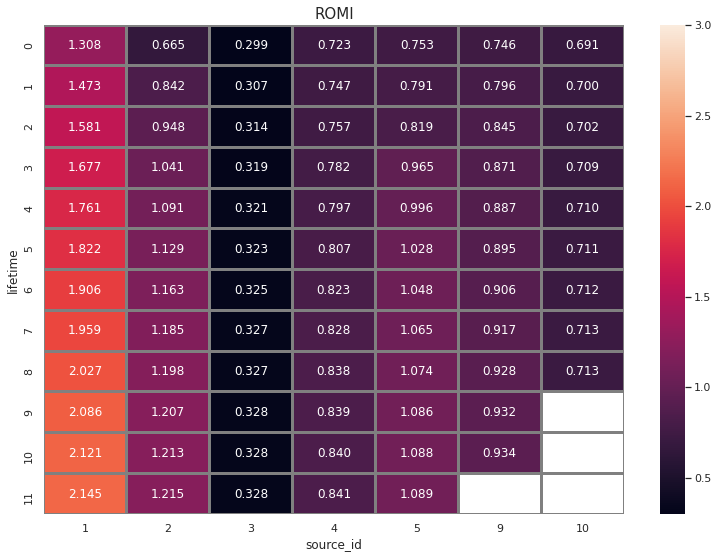

In [184]:
plt.figure(figsize=(13, 9))
plt.title('ROMI', fontsize=15)
sns.heatmap(output_source_romi, annot=True,fmt='.3f', linewidths=2, linecolor='gray',vmax=3);
plt.xlabel('source_id')
plt.ylabel('lifetime')
plt.show()

Привлечение покупателей из первого источника окупилось сразу в первый месяц жизни когорт.  
Затраты на источники 2 и 5 в среднем окупились на третий-четвертый месяц жизни когорт. Затраты на источник 4 окупились на 84%. Источник 9  медленно продвигается и уже окупился на 93%.
Источники 3 имеет самый низкий показатель окупаемости.

## Шаг 3. Общий вывод

Целью нашего исследования было помочь маркетологам оптимизировать маркетинговые затраты.

У нас в распоряжении были данные с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта, выгрузка всех заказов за этот период, статистика рекламных расходов.

#### Мы изучили как люди пользуются продуктом.  
Посмотрели, сколько в среднем посетителей приходит на сайт в день/неделю/месяц. Среднее количество уникальных посетителей в день равно 908 человек. Стоит отметить, что гораздо больше посетителей предпочитают заходить с настольного компьютера, чем с устройств `touch`. Больше всего посетителей в день приходят из источников № 4 и 3. Из источников №6 и 7 вообще практически никто не приходит.
  
Если в начале рассматриваемого периода среднее количество посетителей в день колебалось около 500 человек, то с октября по март оно возросло до 1000 человек в день.  
  
С октября 2017 по март 2018 количество посетителей в неделю было заметно больше. В августе 2017 года был большой спад количества посетителей. Среднее количество посетителей в неделю - 5716 человек.  
  
Среднее количество посетителей в месяц - 23228 человек. До сентября 2017 года разница в количестве пользователей на разных устройствах была стабильна. Уже в ноябре произошло сильное увеличение числа посетителей с устройства `desktop`, а вот на устройствах `touch` заметное плато. 

Мы установили, что пользователи в среднем проводят одну сессию в день. 
  
  
Также мы рассчитали среднюю продолжительность сессии - 300 секунд. Для покупки этого времени вполне достаточно. Также увидели в распределении около 15% сессий длины 60 секунд. Видимо, эти пользователи только заглядывали ненадолго, чтобы  вернуться позже.

Обнаружили около 10% сессий нулевой длительности. Это значит, что пользователь просто в этой сессии ничего не сделал, только перешел на сайт. Может быть ему нужна была главная страница, может быть, просто вкладка в браузере осталась и автоматически подгрузилась.
  
На количество сессий в день не влияют ни устройства, ни источники.  
А вот средняя продолжительность сессии на устройствах `desktop` длиннее, чем на устройствах `touch`.
  
Также мы исследовали, как часто люди возвращаются.  
Процент повторных визитов невысок. Максимум 8,5%. Начиная с сентябрьской когорты в первую неделю `Retention Rate` заметно убывает с 8.5% до 4.2% в апреле. Также внутри каждой когорты снижение коэффициента удержания до 2% ускоряется. В первой когорте он снижается довольно медленно (относительно начального уровня на первой неделе жизни в 7.9% и не падает ниже 4%).
  
В таблице `Retention Rate` устройства `touch` все показатели ниже в среднем на 1%, чем в таблице `desktop`. Пользователи с устройств `touch` возвращаются реже, чем пользователи устройств `desktop`.  
  
Лучшие результаты (в пределах 7-8%) `Retention Rate` у источников №2 и 9. Из источника №3, 5 и 10 практически никто не возвращается.

#### Мы рассмотрели, когда люди начинают покупать.  
  
75% посетителей совершают покупку в пределах двух дней после первой сессии. А 50% из них покупают сразу же. Эти показатели не отличаются в зависимости от устройства или рекламного источника.
  
Конверсия посетителей в покупатели равна 14.62%.   
  
  
Мы провели когортный анализ и изучили, сколько покупок совершается за период 6 месяцев.  
Наибольшее число заказов было в когорте декабря 2017 года. Но уже в первый месяц жизни в этой когорте было меньше заказов, чем в ноябрьской. Сильный рост покупок соответствует периоду повышения посещаемости с октября по март.
В первой июньской когорте сохранается достаточно большое число заказов вплоть до марта. Но в каждой когорте с каждым месяцем жизни количество покупок убывает. Самый большой спад продаж уже на первом месяце жизни был в апрельской когорте.   
Среднее число заказов на одного пользователя по всем когортам равно 1. То есть люди не возвращаются. Число заказов возрастает в сентябре-октябре, число покупателeй возрастает, но это новые покупатели, которые совершают в среднем 1 покупку за 6 месяцев.  
  
В среднем по всем когортам за период 6 месяцев на пользователей тип устройства слабо влияет на количество заказов на одного пользователя. На устройствах `desktop` значение чуть выше. Из источников 1 и 2 покупок было чуть больше в пересчете на одного пользователя за 6 месяцев.  
   
Больше всего заказов приходит из источников 3 и 4.
  
Средний чек равен 5 рублей. На устройствах `desktop` он выше на 1 рубль, чем на устройствах `touch`.  
Самый большой средний чек у источника №2. Источники №1, 3, 4 и 5 колеблются с разницей в 1 рубль. Сильно проседают источники №7, 9, 10. 
  
Также посчитали `LTV`. В среднем каждый покупатель из первой когорты принес по 11.88 рублей выручки за год использования сайта. Максимальную сумму принесли покупатели сентябрьской когорты - 13.43 рубля за 9 месяцев. С января 2018 года LTV приближается к полученному значению среднего чека.  
  
В основном, пользователи устройства `desktop` приносят больше денег. До декабря здесь сохраняются большие суммы. Но начиная с марта значения `ltv` по устройствам уже не сильно отличаются и колеблются около значения среднего чека.  
  
Больше всего денег приносят покупатели из источников №1, 2 и 5.

#### Также мы посмотрели, когда окупаются вложения в маркетинг.

Всего потрачено 329131.62 руб.  
Затраты возрастают с октября 2017 по апрель 2018 года. Максимальная сумма была потрачена 24 ноября 2017 (перед максимальным чеком, полученным 10 декабря). Больше всего средств потрачено на рекламный источник 3.
  
Мы выяснили, что для первой когорты LTV больше CAC, значит, затраты на привлечение покупателей окупились.

Мы установили расходы на привлечение одного покупателя для каждого источника. Больше всего денег тратится на привлечение людей из источника 3 и 2. Максимальное значение вложений в источник №3 было в августе 2017 года и равно 19.14 рублей на привлечение одного пользователя. Максимальная сумма за привлечение одного клиента с источника №2 равна 11.91 рублей.  
  
Подсчитали, насколько окупились расходы.  
Привлечение покупателей из первого источника окупилось сразу в первый месяц жизни когорт.
Затраты на источники 2 среднем окупились на третий месяц жизни когорт, на источник 5 - на пятый месяц жизни когорт. `ROMI` для источника 4 равен 84% на последний месяц жизни когорты, хотя этот источник лидирует по количеству заказов. Но `LTV`, начиная с декабря для этого источника меньше суммы среднего чека.  
Источник 9 окупился на 93%, 10 - на 71%. Источник 3 имеет низкие показатели окупаемости.

# Рекомендации

Так как было выявлено, что больше посетителей заходят с устройства `desktop`, нужно проверить, всё ли в порядке с мобильной версией приложения. Проанализировать, что происходило в ноябре 2017 года и перед этим, так как в это время разница между числом посетителей с устройств резко возрасла.

На источник №3 траты самые большие. Окупаемость - около 30%. `Retention Rate` не достигает 3%. Количество заказов из этого источника больше, чем у остальных источников (кроме четвертого), но средний по когортам `LTV` этого источника редко превосходит сумму среднего чека. Не стоит продолжать столько вкладывать в источник №3.

Если посмотреть на `LTV`, то значение метрики больше у источников №1, 2, 5. Они же (и источник 9) хорошо окупаются. Особенно расходы на источник №1. Также и по среднему числу заказов на одного покупателя источники 1 и 2 лидируют. Хотя расходов на источник 1 уходит меньше. Также у источника №2 средний чек выше, чем у остальных. В дальнейшем стоит больше вкладывать денег в рекламные источники №1, 2 и 5.

Посетители из источников №3, 5 и 10 практически не возвращаются. Лучшие показатели возврата у источников №2 и 9. Но даже лучшие показатели низкие. Это тревожный знак.

Один из вариантов повышения средней продолжительности сессии и коэффициента возврата посетителей - придумать викторины с вопросами по прошедшим или будущим мероприятиям (например, о героях фильма) и призами ввиде баллов на последующие покупки. Так люди будут проводить больше времени на сайте, у них будет стимул вернуться, если они выиграют баллы на последющие покупки.

Так как средний чек покупателей с устройств `touch` ниже, целесообразно показывать им сопутствующие товары при покупке или напоминать им о грядущих событиях, которыми они интересовались в прошлом, если есть такая техническая возможность.